In [1]:
import sys
sys.path.insert(0, "..")
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import smc_samplers as smp
from particles import kalman
from particles import resampling
from particles import mcmc
from particles import rao_blackwell
from particles import plotting_util
import particles
import corner
from scipy.linalg import expm
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}",
})

np.random.seed(1)

Set up Algae model

transformed parameters: a=10.0, b=10000, tau=0.025, B=100.0, Omega=135.64659966250537


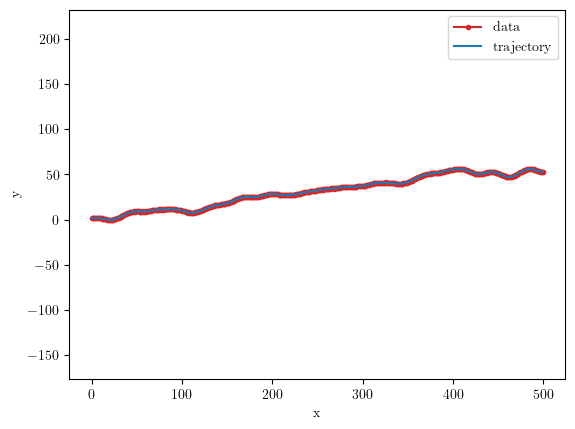

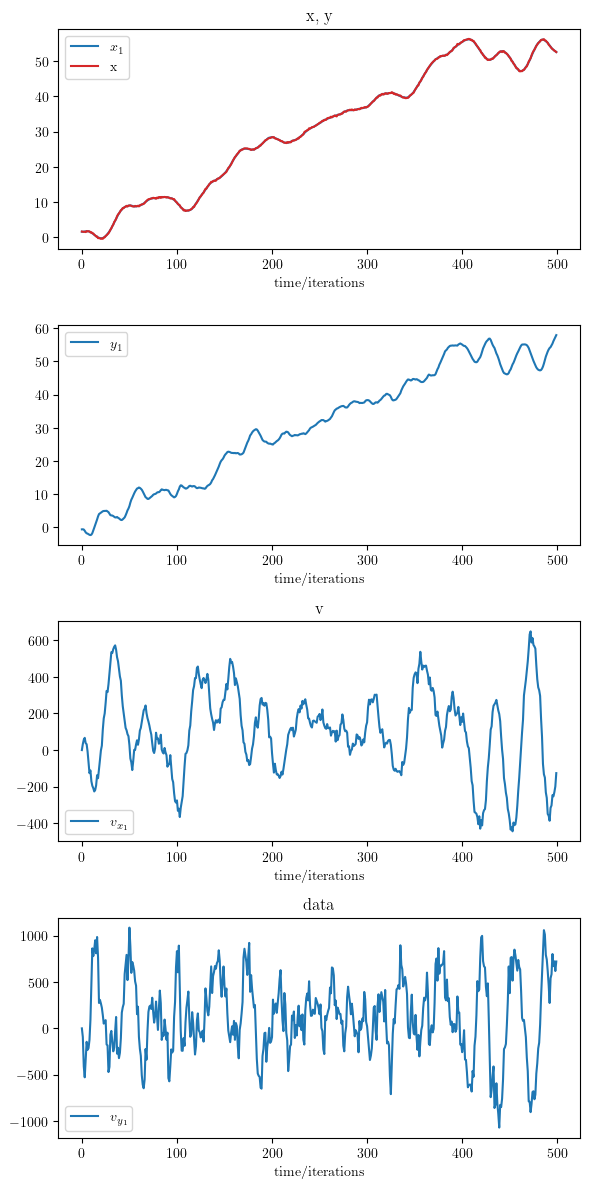

In [2]:
dt = 0.001
    
m = 1
my = 0.5
gammax = 10
gammay = 40.0
b = 10000
sigma_x = 100.0 # = kB * T/m = B
sigmaobs = 0.1

a = gammax/m
tau = 2*my/gammay
B = sigma_x
Omega = np.sqrt(b*m/my-1/tau**2)

print(f"transformed parameters: a={a}, b={b}, tau={tau}, B={B}, Omega={Omega}")

class oscillatingKernel(kalman.MVLinearGauss):
    def __init__(self, **kwargs):
        default_parameters = {'m': m, 'my': my, 'gammax': gammax, 'gammay': gammay, 'b': b, 'sigma_x': sigma_x, 'sigmaobs': sigmaobs}    
        self.__dict__.update(default_parameters)
        self.__dict__.update(kwargs)
        
        # forward propagation of model dynamics (differential equation form)
        A = np.array([[0.,                  0.,                1.,                   0.],
                      [0.,                  0.,                0.,                   1.],
                      [-self.b,             self.b,            -self.gammax/self.m,  0.],
                      [self.b*self.m/self.my,              -self.b*self.m/self.my,           0.,                   -self.gammay/self.my]
                      ])
        F = expm(A*dt) # forward propagation (discretised form)
        G = np.array([[1.0, 0.0, 0.0, 0.0]]) # observation of only x 
        covX = dt*np.diag([0.000001, 0.000001, self.gammax**2/m*self.sigma_x**2, self.gammay**2/my*self.sigma_x**2])
        try:
          assert np.linalg.matrix_rank(covX) == 4
        except AssertionError:
          # something went wrong, plot culprit
          print(f"parameters: m={self.m}, my={self.my}, b={self.b}, gammax={self.gammax}, gammay={self.gammay}, sigma_x={self.sigma_x}, sigmaobs={self.sigmaobs}")
        # print(covX)
        covY = np.diag([self.sigmaobs**2])
        mu0 = np.zeros((4,),dtype=float)
        cov0 = 1*np.eye(4,dtype=float)
        kalman.MVLinearGauss.__init__(self, F=F, G=G, covX=covX, covY=covY, mu0=mu0, cov0=cov0)        

model = oscillatingKernel()


traj, data = model.simulate(500)
traj = np.vstack(traj)
data = np.vstack(data)

plt.figure()
plt.plot(data[:,0], '.-', label="data", color="tab:red")
plt.plot(traj[:,0], '-', label="trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis("equal")
#plt.savefig("traj_xy.png", dpi=300)

plt.figure(figsize=(6,12))
plt.subplot(411)
plt.plot(traj[:,0], label="$x_1$")
plt.plot(data[:,0], label="x", color="tab:red")
plt.xlabel("time/iterations")
plt.legend()
plt.title("x, y")
plt.subplot(412)
plt.plot(traj[:,1], label="$y_1$")
plt.xlabel("time/iterations")
plt.legend()
plt.subplot(413)
plt.plot(traj[:,2], label="$v_{x_1}$")
plt.xlabel("time/iterations")
plt.legend()
plt.title("v")
plt.subplot(414)
plt.plot(traj[:,3], label="$v_{y_1}$")
plt.xlabel("time/iterations")
plt.legend()
plt.title("data")
plt.tight_layout()
#plt.savefig("traj_time_spatial.png", dpi=300)

Kalman-based state inference:

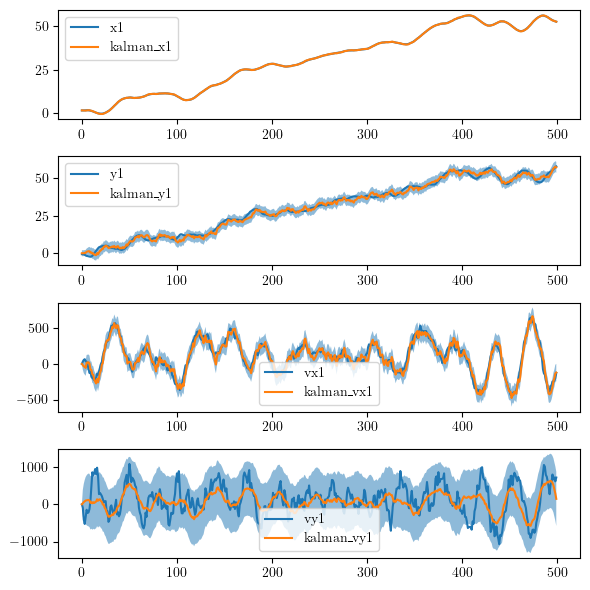

In [3]:
# do inference
kalm = kalman.Kalman(model, data)
kalm.filter()

filtering = kalm.filt
means = np.vstack([filtering[k].mean for k in range(len(filtering))])
covs = np.stack([filtering[k].cov for k in range(len(filtering))])


plt.figure(figsize=(6,6))
labels = ["x1", "y1", "vx1", "vy1", "x2", "y2", "vx2", "vy2"]
for n in range(4):
    plt.subplot(4,1,n+1)
    plt.plot(traj[:,n], label=labels[n])
    plt.plot(means[:,n], label=f'kalman_{labels[n]}')
    plt.fill_between(range(len(filtering)), means[:,n] - 2*np.sqrt(covs[:,n,n]), means[:,n] + 2*np.sqrt(covs[:,n,n]), alpha=0.5)
    plt.legend()
plt.tight_layout()

Load data

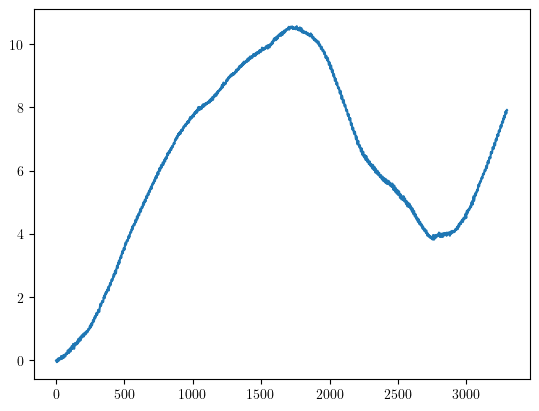

In [4]:
data = np.loadtxt("..\Data\Algae\H10 Synchronous\S2.txt", skiprows=1)[0:,1] # just take one coordinate of trajectory, since model is effectively one-dimensional
data -= data[0]
plt.figure()
plt.plot(data);

Parameter inference

Iteration 0, 2025-07-21 21:12:34.673709, b=14.864923042413402, gammax=87.26927242579448, gammay=220.5297955231939, my=3.6725560667067523, sigma_x=11.005108897914537
Iteration 2500, 2025-07-21 21:28:56.761620, acc. rate=0.311, b=29.803466311782728, gammax=5.365175631073011, gammay=22.794039747759776, my=6.514954387404947, sigma_x=1.1722090086091332
Iteration 5000, 2025-07-21 21:44:14.283399, acc. rate=0.294, b=7.781541931915676, gammax=3.2356522786722914, gammay=317.9477389607938, my=3.939320528129117, sigma_x=1.6751382183152226
Iteration 7500, 2025-07-21 21:57:02.687970, acc. rate=0.267, b=16.84169739253488, gammax=6.321373974712726, gammay=885.467097070214, my=4.487487886189369, sigma_x=0.7830545313547228
Iteration 10000, 2025-07-21 22:09:51.638321, acc. rate=0.247, b=17.249413785985332, gammax=3.955572971801617, gammay=333.21790610791567, my=1.82655870519109, sigma_x=1.3023771437151446
Iteration 12500, 2025-07-21 22:23:04.030254, acc. rate=0.239, b=22.567275637575978, gammax=6.534468

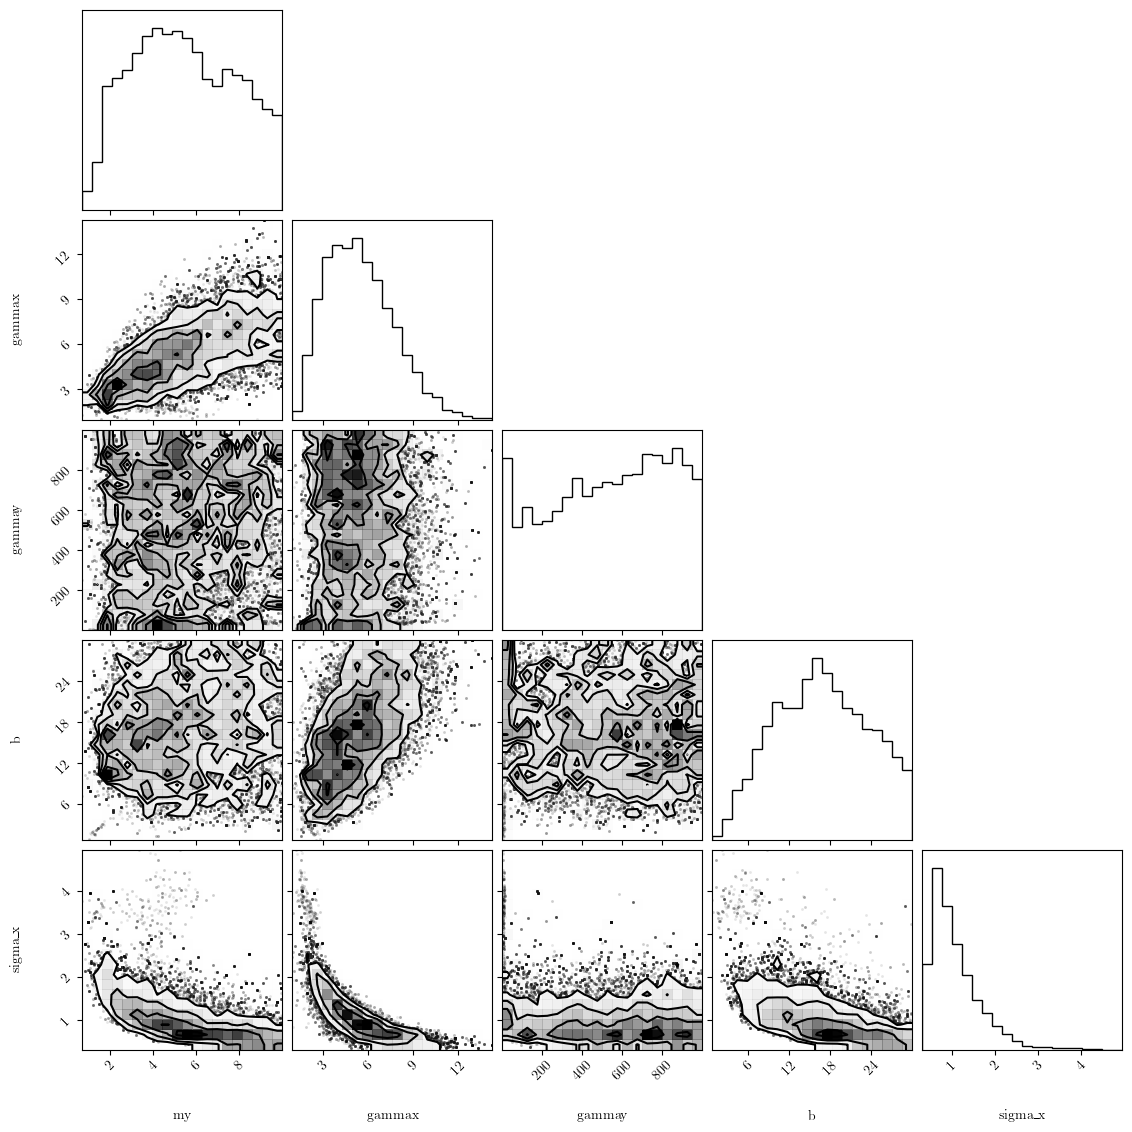

In [5]:
prior_dict = {
  'my': dists.Uniform(0.001, 10.0),
  'gammax': dists.Uniform(0.000001, 100.0),
  'gammay': dists.Uniform(0.000001, 1000.0),
  'b': dists.Uniform(0.0, 30.0),
  'sigma_x':dists.Uniform(0.000001, 30.0),
}
    
my_prior = dists.StructDist(prior_dict)

my_kmmh = mcmc.KMMH(ssm_cls=oscillatingKernel, prior=my_prior, data=data, niter=50000, verbose=20)
my_kmmh.run()

burnin = 1000
array_samples = np.stack([my_kmmh.chain.theta[p][burnin:] for p in prior_dict.keys()])
corner.corner(array_samples.T, truths=None, labels=[p for p in prior_dict.keys()])
plt.savefig(f"corner_chlamydomonas_mass1_S2.png", dpi=300)

load different data

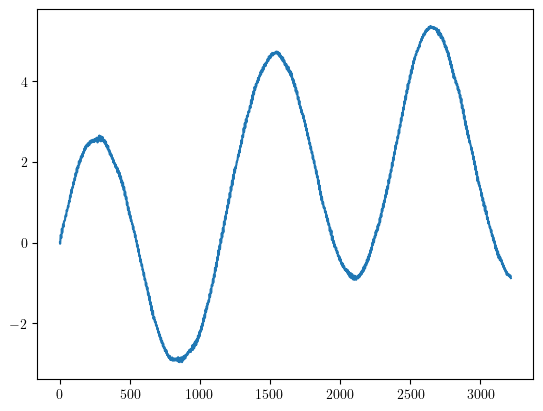

In [6]:
data = np.loadtxt("..\Data\Algae\H10 Synchronous\S3.txt", skiprows=1)[0:,1] # just take one coordinate of trajectory, since model is effectively one-dimensional
data -= data[0]
plt.figure()
plt.plot(data);

Iteration 0, 2025-07-22 01:20:36.484799, b=24.740813740320753, gammax=48.26034052642945, gammay=388.0355326822791, my=7.448733312590921, sigma_x=15.280515473681003
parameters: m=1, my=0.021814738625258862, b=25.186566044979664, gammax=0.21912527405184634, gammay=956.8254286584436, sigma_x=25.715093013306678, sigmaobs=0.1
parameters: m=1, my=0.07138314185638285, b=14.936953439655102, gammax=0.4238271520620955, gammay=896.9110805295304, sigma_x=27.61172442802668, sigmaobs=0.1
parameters: m=1, my=0.052154191482723045, b=11.875087565356, gammax=0.2607530428580751, gammay=891.3493695074461, sigma_x=28.890869130459567, sigmaobs=0.1
Iteration 2500, 2025-07-22 01:36:07.427758, acc. rate=0.331, b=25.1723688688665, gammax=0.8859636723091084, gammay=308.5533699435137, my=0.030678001089797725, sigma_x=11.932815717470284
parameters: m=1, my=0.007724413673876395, b=29.86872899901932, gammax=0.16878545992191474, gammay=910.2954993039913, sigma_x=29.347033058977406, sigmaobs=0.1
parameters: m=1, my=0.

parameters: m=1, my=0.04519143086124086, b=26.975520976202457, gammax=0.3889449339942105, gammay=975.2299443939904, sigma_x=24.575468280539003, sigmaobs=0.1
parameters: m=1, my=0.06436032042794726, b=27.77733253270182, gammax=0.4060052310691984, gammay=886.622242027201, sigma_x=29.69394158989031, sigmaobs=0.1
parameters: m=1, my=0.04669814889747861, b=27.39696158698382, gammax=0.4072058792514293, gammay=999.2994223130353, sigma_x=23.86592329498611, sigmaobs=0.1
parameters: m=1, my=0.03547607256015334, b=26.374676365088888, gammax=0.24618473799745832, gammay=995.4133334551148, sigma_x=24.636705019867698, sigmaobs=0.1
parameters: m=1, my=0.007193310001124102, b=27.69990142896179, gammax=0.2980038170920832, gammay=947.6103028112913, sigma_x=25.605710508508068, sigmaobs=0.1
parameters: m=1, my=0.046753586757480446, b=26.257195673650603, gammax=0.5804095801591118, gammay=996.8404199734754, sigma_x=24.15579503763268, sigmaobs=0.1
parameters: m=1, my=0.023103576837873292, b=23.079196183169802

parameters: m=1, my=0.0726294084064649, b=23.366153228461588, gammax=0.022670106855111838, gammay=905.0948951014406, sigma_x=27.109133970751365, sigmaobs=0.1
Iteration 27500, 2025-07-22 03:35:38.578406, acc. rate=0.207, b=20.268679243398566, gammax=1.6300909906992065, gammay=612.4838062262655, my=0.07109756604094217, sigma_x=7.105770463115851
parameters: m=1, my=0.02369563067572078, b=20.775881193626986, gammax=0.2680604435248057, gammay=908.5354690253768, sigma_x=29.881170929317044, sigmaobs=0.1
parameters: m=1, my=0.0057420275937265786, b=28.15263496632393, gammax=0.15183599795274427, gammay=919.762624898904, sigma_x=26.43105217950198, sigmaobs=0.1
parameters: m=1, my=0.034169200935122886, b=28.003055522150003, gammax=0.4933415978292953, gammay=993.4668322626065, sigma_x=24.6400510825858, sigmaobs=0.1
parameters: m=1, my=0.04013263850399931, b=28.7009805473257, gammax=0.6077224049697094, gammay=939.2736587451798, sigma_x=27.7786285084645, sigmaobs=0.1
parameters: m=1, my=0.0135890520

parameters: m=1, my=0.033274028332205635, b=25.624893835473657, gammax=0.7028084310307106, gammay=975.811794379907, sigma_x=24.540351964976885, sigmaobs=0.1
Iteration 37500, 2025-07-22 04:22:31.279258, acc. rate=0.199, b=29.004512715664006, gammax=0.5707539291298341, gammay=178.02427248554736, my=0.052343529290568014, sigma_x=21.15095241854683
parameters: m=1, my=0.02312645484359606, b=21.884138568472046, gammax=0.13631655797413866, gammay=901.8607455378875, sigma_x=29.064706067765375, sigmaobs=0.1
parameters: m=1, my=0.017842669537384403, b=23.56021326233181, gammax=0.40734845416081417, gammay=980.7305100121102, sigma_x=24.371544075956784, sigmaobs=0.1
parameters: m=1, my=0.046457787290497245, b=27.54462415783329, gammax=0.11437006512600606, gammay=912.4801861122328, sigma_x=29.867571619628908, sigmaobs=0.1
parameters: m=1, my=0.029536001160371847, b=27.24147461863788, gammax=0.23766359288926964, gammay=989.096457610389, sigma_x=24.861425015921327, sigmaobs=0.1
parameters: m=1, my=0.0

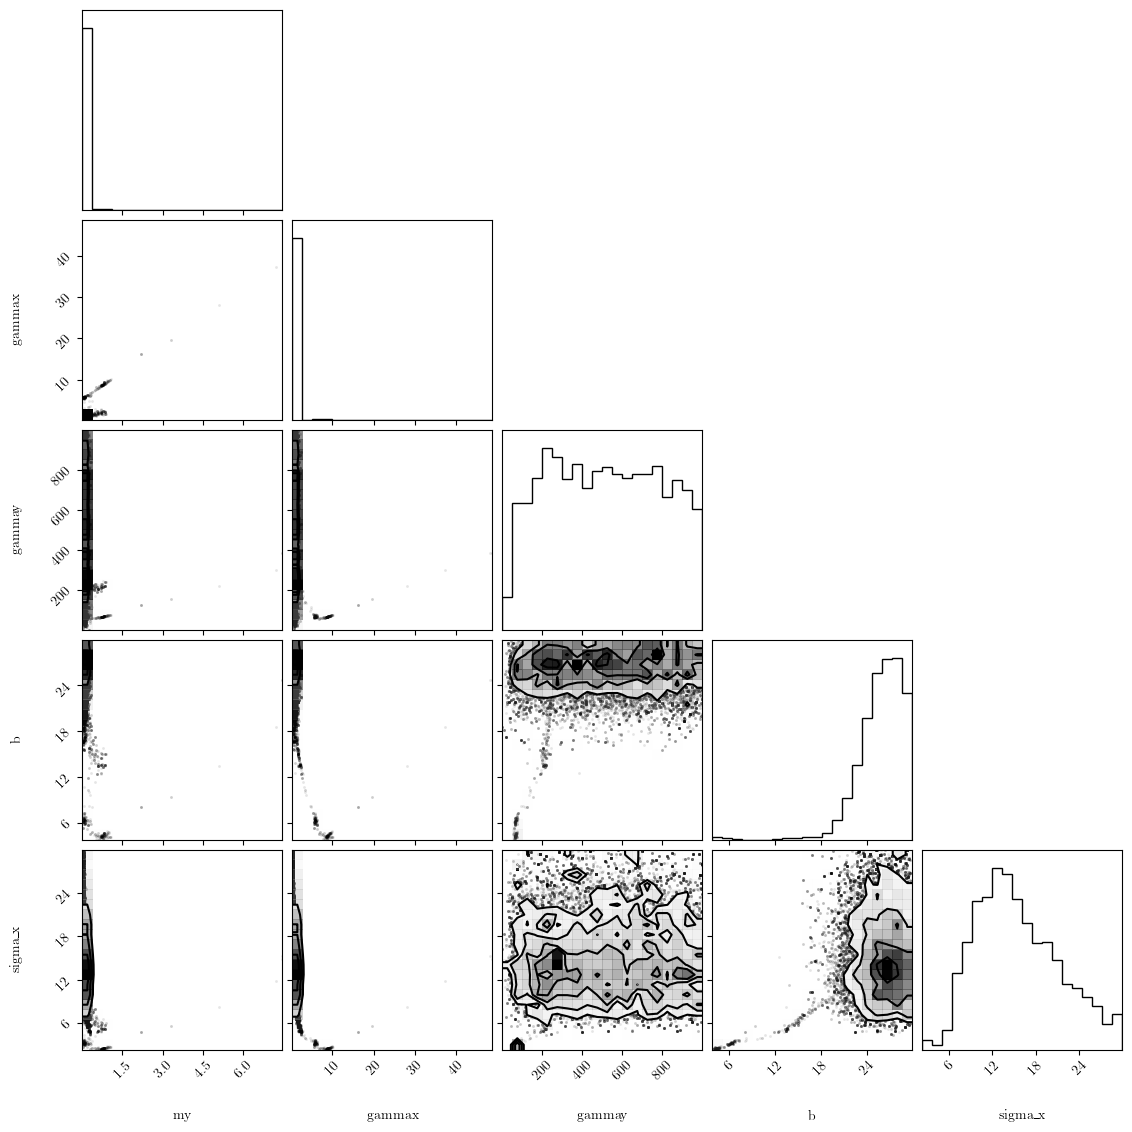

In [7]:
my_kmmh = mcmc.KMMH(ssm_cls=oscillatingKernel, prior=my_prior, data=data, niter=50000, verbose=20)
my_kmmh.run()

burnin = 0*1000
array_samples2 = np.stack([my_kmmh.chain.theta[p][burnin:] for p in prior_dict.keys()])
corner.corner(array_samples2.T, truths=None, labels=[p for p in prior_dict.keys()])
plt.savefig(f"corner_chlamydomonas_mass1_S3.png", dpi=300)

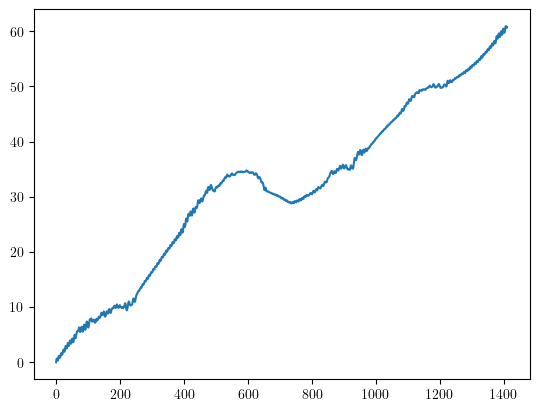

In [8]:
data = np.loadtxt("..\Data\Algae\H10 Wobbler\W2.txt", skiprows=1)[0:,1] # just take one coordinate of trajectory, since model is effectively one-dimensional
data -= data[0]
plt.figure()
plt.plot(data);

Iteration 0, 2025-07-22 05:20:21.958593, b=23.436431105794682, gammax=55.31468174664295, gammay=688.0911764116821, my=1.2128581832274046, sigma_x=3.9333792861996484
parameters: m=1, my=1.6463298984529426, b=24.70534591915872, gammax=99.55468577955054, gammay=996.8577380244033, sigma_x=24.1403418388686, sigmaobs=0.1
parameters: m=1, my=1.6433577366223637, b=24.683742499764442, gammax=99.66132184379036, gammay=997.1911473942647, sigma_x=24.199607545393395, sigmaobs=0.1
parameters: m=1, my=1.5580852862956827, b=24.684302170166685, gammax=99.04302945755848, gammay=997.6957247093865, sigma_x=23.879234602355858, sigmaobs=0.1
parameters: m=1, my=1.5988367409780966, b=24.68594963957133, gammax=99.29389594424303, gammay=997.2456954433476, sigma_x=24.011345236706955, sigmaobs=0.1
parameters: m=1, my=1.677474119649394, b=24.67690450038931, gammax=99.97024124160768, gammay=997.2209102962299, sigma_x=24.358461300926898, sigmaobs=0.1
parameters: m=1, my=1.57520636402439, b=24.696584504467264, gammax

parameters: m=1, my=1.5958821775330883, b=24.696090342070345, gammax=99.2097209465253, gammay=997.128086592847, sigma_x=23.9644644088167, sigmaobs=0.1
parameters: m=1, my=1.5649901658131014, b=24.70276983428441, gammax=98.9315489015457, gammay=997.13149156797, sigma_x=23.820240925000206, sigmaobs=0.1
parameters: m=1, my=1.6052785802337828, b=24.698718984384147, gammax=99.26307640400933, gammay=997.0339046771301, sigma_x=23.991855258371203, sigmaobs=0.1
parameters: m=1, my=1.5787850508433305, b=24.696545695453853, gammax=99.06111416955855, gammay=997.0986838971139, sigma_x=23.88922338841647, sigmaobs=0.1
parameters: m=1, my=1.664251750677771, b=24.687690779145942, gammax=99.77199307401078, gammay=996.9369753886534, sigma_x=24.256312714033335, sigmaobs=0.1
parameters: m=1, my=1.593662271604974, b=24.697205111183237, gammax=99.18103019857527, gammay=997.092866736596, sigma_x=23.94980155101323, sigmaobs=0.1
parameters: m=1, my=1.6476450254450172, b=24.686709507057074, gammax=99.65200105810

parameters: m=1, my=1.6251354696108438, b=24.703843410260646, gammax=99.40090949060533, gammay=997.0046984156038, sigma_x=24.058799721560305, sigmaobs=0.1
parameters: m=1, my=1.6658447987522378, b=24.68859099344853, gammax=99.77981622438747, gammay=996.9287473690381, sigma_x=24.259762346856764, sigmaobs=0.1
parameters: m=1, my=1.6271272205116667, b=24.694678690837165, gammax=99.45192921992997, gammay=997.0011221875094, sigma_x=24.08989956280965, sigmaobs=0.1
parameters: m=1, my=1.660353419283448, b=24.69455725290245, gammax=99.70033355813746, gammay=996.8558579795407, sigma_x=24.217493898231606, sigmaobs=0.1
parameters: m=1, my=1.5609888943992587, b=24.702081511384478, gammax=98.89253097527462, gammay=997.083137808529, sigma_x=23.80149489564039, sigmaobs=0.1
parameters: m=1, my=1.57477574145552, b=24.702810371142135, gammax=99.02772637636932, gammay=997.2197863032194, sigma_x=23.867740920695386, sigmaobs=0.1
parameters: m=1, my=1.6912443527816585, b=24.691492301515204, gammax=99.966024

parameters: m=1, my=1.6514018978361111, b=24.685722900942615, gammax=99.6667526364509, gammay=996.9029168623391, sigma_x=24.20442103270501, sigmaobs=0.1
parameters: m=1, my=1.6808445512444696, b=24.67809932389562, gammax=99.93319222678048, gammay=996.8782761341973, sigma_x=24.343614444417465, sigmaobs=0.1
parameters: m=1, my=1.6480743808751734, b=24.69230581642428, gammax=99.6129601634235, gammay=996.8869185810233, sigma_x=24.17409170728272, sigmaobs=0.1
Iteration 2500, 2025-07-22 05:25:20.019433, acc. rate=0.164, b=24.681077648905784, gammax=99.99154646295605, gammay=996.8373070994869, my=1.690108512631223, sigma_x=24.37213916404656
parameters: m=1, my=1.648136830879173, b=24.696852876879305, gammax=99.5959684255156, gammay=996.8811182553063, sigma_x=24.163218597833232, sigmaobs=0.1
parameters: m=1, my=1.6593328989490839, b=24.681446163991488, gammax=99.74691531719448, gammay=996.8989864362478, sigma_x=24.247238677348136, sigmaobs=0.1
parameters: m=1, my=1.6416622659112554, b=24.68512

parameters: m=1, my=1.6920055031296448, b=24.69462724531068, gammax=99.95542617844691, gammay=996.827570585158, sigma_x=24.346753697143953, sigmaobs=0.1
parameters: m=1, my=1.6759552665944806, b=24.7009736242153, gammax=99.8025050914583, gammay=996.8390512088205, sigma_x=24.266042395231427, sigmaobs=0.1
parameters: m=1, my=1.6817015905931314, b=24.691993175895856, gammax=99.88129565673316, gammay=996.8288680767773, sigma_x=24.31085006688611, sigmaobs=0.1
parameters: m=1, my=1.6228241777191748, b=24.69935455429393, gammax=99.40396838835487, gammay=997.0302664630801, sigma_x=24.06266157577123, sigmaobs=0.1
parameters: m=1, my=1.6436311985937788, b=24.695132539281285, gammax=99.57459608468582, gammay=996.9349681031156, sigma_x=24.15259030352061, sigmaobs=0.1
parameters: m=1, my=1.635853461751246, b=24.693637521290302, gammax=99.52041583173208, gammay=996.964255201184, sigma_x=24.12540253804617, sigmaobs=0.1
parameters: m=1, my=1.659172405250299, b=24.696881041738216, gammax=99.68223915003

parameters: m=1, my=1.6779852085097688, b=24.709129095246624, gammax=99.78492145825746, gammay=996.8167568006131, sigma_x=24.253010482729987, sigmaobs=0.1
parameters: m=1, my=1.675452948812416, b=24.68458190879848, gammax=99.89427399377676, gammay=997.0524840390167, sigma_x=24.31784323438791, sigmaobs=0.1
parameters: m=1, my=1.6655994302165733, b=24.703035975268833, gammax=99.71737681642963, gammay=996.8783653721457, sigma_x=24.22158411233665, sigmaobs=0.1
parameters: m=1, my=1.662307316123307, b=24.698558534355463, gammax=99.70902142068333, gammay=996.897201490856, sigma_x=24.219225929284633, sigmaobs=0.1
parameters: m=1, my=1.6491473979813644, b=24.683460863975867, gammax=99.71960702624918, gammay=997.2759846880848, sigma_x=24.22677358201382, sigmaobs=0.1
parameters: m=1, my=1.6790807451663727, b=24.69914772362768, gammax=99.85043177323513, gammay=996.9266739875585, sigma_x=24.290102749926078, sigmaobs=0.1
parameters: m=1, my=1.6436483577303904, b=24.67270488775623, gammax=99.7220144

parameters: m=1, my=1.5516137880263208, b=24.530924189160217, gammax=99.77656242184747, gammay=999.0961818651133, sigma_x=24.307175790467163, sigmaobs=0.1
parameters: m=1, my=1.6608926848706596, b=24.677456361090695, gammax=99.79925902192149, gammay=997.0539658009374, sigma_x=24.27316140839285, sigmaobs=0.1
parameters: m=1, my=1.550405908054795, b=24.556625028148094, gammax=99.6206107241787, gammay=998.7911004427194, sigma_x=24.219252529621183, sigmaobs=0.1
parameters: m=1, my=1.5436643867282265, b=24.493188289537223, gammax=99.93876515829967, gammay=999.626134867256, sigma_x=24.401127382183496, sigmaobs=0.1
parameters: m=1, my=1.5427718059216622, b=24.50374978947803, gammax=99.84346525400012, gammay=999.3376776715573, sigma_x=24.351559841766775, sigmaobs=0.1
parameters: m=1, my=1.6455723885545297, b=24.635950054751724, gammax=99.92837647380708, gammay=997.6693446373903, sigma_x=24.350929249577838, sigmaobs=0.1
parameters: m=1, my=1.5512061818049245, b=24.493514733101424, gammax=99.963

parameters: m=1, my=1.5606472593677398, b=24.505295085203294, gammax=99.9404185889438, gammay=999.1005575385409, sigma_x=24.402204860169753, sigmaobs=0.1
parameters: m=1, my=1.5014025315792145, b=24.417562148689846, gammax=99.89808676433917, gammay=999.8818823412166, sigma_x=24.41338377843378, sigmaobs=0.1
parameters: m=1, my=1.5416538024855144, b=24.514021147379967, gammax=99.73248954284823, gammay=998.9907370156238, sigma_x=24.293845084810748, sigmaobs=0.1
parameters: m=1, my=1.5081726095870436, b=24.406763699725275, gammax=99.96915025635447, gammay=999.7497494422025, sigma_x=24.4565231770244, sigmaobs=0.1
parameters: m=1, my=1.5578151423833453, b=24.47258649959868, gammax=99.97275838336132, gammay=998.7760957293438, sigma_x=24.438350163856292, sigmaobs=0.1
parameters: m=1, my=1.582194851911564, b=24.517939443689997, gammax=99.8957799885956, gammay=998.1118941047986, sigma_x=24.385619833093365, sigmaobs=0.1
parameters: m=1, my=1.5078325057430773, b=24.403320056401267, gammax=99.98417

parameters: m=1, my=1.5418476734431077, b=24.45720190153927, gammax=99.88465513717846, gammay=998.7175427897022, sigma_x=24.402023905724455, sigmaobs=0.1
parameters: m=1, my=1.4900460212318203, b=24.37043122458272, gammax=99.84358211235994, gammay=999.1974043307988, sigma_x=24.41646294612968, sigmaobs=0.1
parameters: m=1, my=1.4294083745099582, b=24.252537788649587, gammax=99.88537714402274, gammay=999.9459356347936, sigma_x=24.484247865315556, sigmaobs=0.1
parameters: m=1, my=1.4399171416480927, b=24.271843284220246, gammax=99.89994585392044, gammay=999.9167471771461, sigma_x=24.482791326591055, sigmaobs=0.1
parameters: m=1, my=1.419287888299097, b=24.217539173457038, gammax=99.89684360623382, gammay=999.8023934003115, sigma_x=24.5083694143715, sigmaobs=0.1
parameters: m=1, my=1.5113747508911026, b=24.39135617527313, gammax=99.84160867273383, gammay=998.6274963719405, sigma_x=24.411792487545146, sigmaobs=0.1
parameters: m=1, my=1.5806295951119942, b=24.43358608431669, gammax=99.887844

parameters: m=1, my=1.081634001540361, b=23.250148257537088, gammax=99.77635312222858, gammay=996.1136297278679, sigma_x=24.947942495116855, sigmaobs=0.1
parameters: m=1, my=0.33050280272330707, b=21.431728617954445, gammax=99.97164052261286, gammay=996.734897138902, sigma_x=25.900193272624886, sigmaobs=0.1
parameters: m=1, my=0.47345399668496635, b=21.731837297153675, gammax=99.93705750078948, gammay=995.7662733004754, sigma_x=25.75174440802251, sigmaobs=0.1
parameters: m=1, my=1.085203966337479, b=23.159374024699105, gammax=99.89531109050151, gammay=994.919771513115, sigma_x=25.06357618759839, sigmaobs=0.1
parameters: m=1, my=0.9494216110877174, b=22.912144039321497, gammax=99.95072334344442, gammay=996.6749917899663, sigma_x=25.188499073885353, sigmaobs=0.1
parameters: m=1, my=0.42244325929532345, b=21.467657076421897, gammax=99.91327378827403, gammay=992.956544823556, sigma_x=25.89704136525022, sigmaobs=0.1
parameters: m=1, my=0.295227467614211, b=21.224002212340743, gammax=99.8494

parameters: m=1, my=0.756233478976954, b=22.272132035864313, gammax=99.91022185940744, gammay=993.0724723727362, sigma_x=25.51333743158051, sigmaobs=0.1
parameters: m=1, my=0.3540476421775419, b=21.490771053403463, gammax=99.92693187129228, gammay=996.55579195086, sigma_x=25.85114322192507, sigmaobs=0.1
parameters: m=1, my=0.7485048423561014, b=22.425231662791667, gammax=99.92724139892016, gammay=996.4081925771022, sigma_x=25.410610426462714, sigmaobs=0.1
parameters: m=1, my=0.4066895432446467, b=21.513833151298925, gammax=99.86388784367315, gammay=994.2562010358578, sigma_x=25.835709806444775, sigmaobs=0.1
parameters: m=1, my=0.7764155012710064, b=22.43590204772547, gammax=99.91995014696049, gammay=995.3255910729823, sigma_x=25.413739684330853, sigmaobs=0.1
parameters: m=1, my=0.006083457019349217, b=20.304601219761306, gammax=99.90316623046644, gammay=989.7524489040387, sigma_x=26.47835014177503, sigmaobs=0.1
parameters: m=1, my=0.2731885097139885, b=20.81737717794359, gammax=99.9265

parameters: m=1, my=0.09702264835258526, b=19.339282139234815, gammax=99.98813456997773, gammay=968.011981233674, sigma_x=27.22494215825524, sigmaobs=0.1
parameters: m=1, my=0.15084741115740669, b=20.21926310112931, gammax=99.95127932573457, gammay=981.9243226758625, sigma_x=26.631628194277493, sigmaobs=0.1
parameters: m=1, my=0.22879804629998982, b=20.03125553769172, gammax=99.92372257316543, gammay=974.7467332029437, sigma_x=26.788182492697718, sigmaobs=0.1
parameters: m=1, my=0.5461168889221762, b=20.83393292572881, gammax=99.98116136351139, gammay=975.9000680746776, sigma_x=26.423995999511117, sigmaobs=0.1
parameters: m=1, my=0.44388662983132754, b=19.98153718015934, gammax=99.99956029220994, gammay=964.5735281665179, sigma_x=26.965706322195263, sigmaobs=0.1
parameters: m=1, my=0.15842012216221146, b=19.706380646984666, gammax=99.92107722415454, gammay=971.7809582790669, sigma_x=26.974680834027033, sigmaobs=0.1
parameters: m=1, my=0.007719877318054985, b=20.024208283943313, gammax=

parameters: m=1, my=0.009580663537226575, b=18.863406107176026, gammax=99.95269236999135, gammay=962.7999336335828, sigma_x=27.491730152609076, sigmaobs=0.1
parameters: m=1, my=0.10231833123786374, b=20.087961197530884, gammax=99.90199851597912, gammay=981.3591230967623, sigma_x=26.675667006059623, sigmaobs=0.1
parameters: m=1, my=0.23943021199500908, b=19.405088246803164, gammax=99.98012181277157, gammay=962.810604277602, sigma_x=27.24899831419331, sigmaobs=0.1
parameters: m=1, my=0.2667144451281563, b=20.32281678740394, gammax=99.94305903131882, gammay=978.6284968164399, sigma_x=26.61575852365209, sigmaobs=0.1
parameters: m=1, my=0.27345633646419, b=19.878797382800435, gammax=99.92607828556002, gammay=969.8873762837206, sigma_x=26.91697951986225, sigmaobs=0.1
parameters: m=1, my=0.0639887467009535, b=18.780654826367968, gammax=99.97266502977995, gammay=958.9290146546675, sigma_x=27.58426247404216, sigmaobs=0.1
parameters: m=1, my=0.09729150681285405, b=19.436565468279195, gammax=99.9

parameters: m=1, my=0.1741543700869289, b=16.585627129600617, gammax=99.9567186763604, gammay=912.7326986065086, sigma_x=29.137404355526552, sigmaobs=0.1
parameters: m=1, my=0.05787400826144491, b=18.911576556971223, gammax=99.98564723440715, gammay=961.7207216285452, sigma_x=27.49769426359545, sigmaobs=0.1
parameters: m=1, my=0.18148820960039036, b=17.884480543419702, gammax=99.9686711519083, gammay=936.8205767541076, sigma_x=28.25686516557833, sigmaobs=0.1
parameters: m=1, my=0.39723527560096283, b=18.18237849077526, gammax=99.98944121352946, gammay=932.8485104835022, sigma_x=28.171446200653403, sigmaobs=0.1
parameters: m=1, my=0.180821603657035, b=16.419323716677045, gammax=99.98452433579128, gammay=909.4437582511205, sigma_x=29.26836537644417, sigmaobs=0.1
parameters: m=1, my=0.21186319737665513, b=18.326233028162157, gammax=99.97317760978507, gammay=943.7746183625362, sigma_x=27.97121746634137, sigmaobs=0.1
parameters: m=1, my=0.10229110197358306, b=16.167050395614336, gammax=99.9

parameters: m=1, my=0.08646209928040358, b=16.39583452555109, gammax=99.94025924356721, gammay=913.0193719344659, sigma_x=29.215387231538607, sigmaobs=0.1
parameters: m=1, my=0.12193420251734746, b=15.657580791169577, gammax=99.93823338519198, gammay=897.5765918447174, sigma_x=29.73812230272227, sigmaobs=0.1
parameters: m=1, my=0.14938142086337547, b=15.659475136679603, gammax=99.96906120731074, gammay=896.5292929623917, sigma_x=29.765596977869112, sigmaobs=0.1
parameters: m=1, my=0.12818706540138192, b=15.732685884095387, gammax=99.90348097416741, gammay=898.5369860444066, sigma_x=29.673184899225465, sigmaobs=0.1
parameters: m=1, my=0.11492853649533705, b=17.659870487130654, gammax=99.98609842459156, gammay=935.6877760066645, sigma_x=28.384689800168452, sigmaobs=0.1
parameters: m=1, my=0.0700637932174873, b=17.504817793086364, gammax=99.97127676685567, gammay=934.7125551928563, sigma_x=28.461466997945774, sigmaobs=0.1
parameters: m=1, my=0.26286101359482583, b=16.68413722635758, gamma

parameters: m=1, my=0.13409788105785733, b=17.284842579707274, gammax=99.95727768316087, gammay=927.6473534215652, sigma_x=28.63806466865083, sigmaobs=0.1
parameters: m=1, my=0.24352423509869098, b=16.11891984621871, gammax=99.8928094129508, gammay=900.5499240451585, sigma_x=29.462433216678097, sigmaobs=0.1
parameters: m=1, my=0.3089680715589697, b=16.410077282403556, gammax=99.95368499159268, gammay=903.3837716498066, sigma_x=29.32454520471346, sigmaobs=0.1
parameters: m=1, my=0.2360404914788889, b=15.411754302301652, gammax=99.92184420558556, gammay=887.7646882226043, sigma_x=29.957022250432015, sigmaobs=0.1
parameters: m=1, my=0.3847808711278408, b=16.656459510665677, gammax=99.93177733913431, gammay=904.5026511419001, sigma_x=29.183545169714606, sigmaobs=0.1
parameters: m=1, my=0.1882525717804413, b=16.605857215456542, gammax=99.91094937614473, gammay=912.2601405786451, sigma_x=29.108702747366912, sigmaobs=0.1
parameters: m=1, my=0.26138103416159536, b=17.761752745735393, gammax=99

parameters: m=1, my=0.1933357852826901, b=15.597939085831461, gammax=99.85469916174792, gammay=892.8231292578572, sigma_x=29.776951225132155, sigmaobs=0.1
parameters: m=1, my=0.1547712572824449, b=16.51438059254394, gammax=99.88251151525218, gammay=911.8878623628465, sigma_x=29.14193055657583, sigmaobs=0.1
parameters: m=1, my=0.14513743795911288, b=15.401999861918348, gammax=99.87506646743603, gammay=891.4170360407813, sigma_x=29.895966509973785, sigmaobs=0.1
parameters: m=1, my=0.21014127500148816, b=15.695410977502819, gammax=99.86332038199005, gammay=893.9501030014964, sigma_x=29.72220873590628, sigmaobs=0.1
parameters: m=1, my=0.1170701808805979, b=16.078760905075235, gammax=99.92503922188232, gammay=905.62108708675, sigma_x=29.441240055983627, sigmaobs=0.1
parameters: m=1, my=0.2771175992143521, b=15.609294307584456, gammax=99.82654858150836, gammay=889.1499011851029, sigma_x=29.79786809647848, sigmaobs=0.1
parameters: m=1, my=0.07314699795920916, b=15.849621125977706, gammax=99.8

parameters: m=1, my=0.09891550663902567, b=15.16212731257388, gammax=99.76085204985175, gammay=888.4065017157641, sigma_x=29.984006329787068, sigmaobs=0.1
parameters: m=1, my=0.08805129744969786, b=15.90701857666175, gammax=99.78668601329143, gammay=902.9975400913686, sigma_x=29.47993157555584, sigmaobs=0.1
parameters: m=1, my=0.1758362658229478, b=15.820709042826243, gammax=99.60581311305494, gammay=896.532460293895, sigma_x=29.499101707947787, sigmaobs=0.1
parameters: m=1, my=0.10769951080036472, b=15.279751525846423, gammax=99.75022819469677, gammay=890.162923037413, sigma_x=29.903029186125114, sigmaobs=0.1
parameters: m=1, my=0.0679545886863287, b=15.955093918203493, gammax=99.84473457130676, gammay=905.0860187398519, sigma_x=29.464282566911596, sigmaobs=0.1
parameters: m=1, my=0.15866083607426057, b=15.785752676136934, gammax=99.83446580517773, gammay=897.8022774881267, sigma_x=29.62096156326537, sigmaobs=0.1
parameters: m=1, my=0.1907929181572629, b=15.614084194547301, gammax=99.

parameters: m=1, my=0.2587439754874053, b=15.88248062040346, gammax=99.73504636507714, gammay=894.6361863168468, sigma_x=29.558602103954243, sigmaobs=0.1
parameters: m=1, my=0.18324787266227413, b=15.234973632591139, gammax=99.71061338817064, gammay=885.7423918794476, sigma_x=29.95321793652275, sigmaobs=0.1
parameters: m=1, my=0.1819172889278774, b=16.226031464550704, gammax=99.85733777847543, gammay=905.1319860082031, sigma_x=29.341776356963347, sigmaobs=0.1
parameters: m=1, my=0.20281032132975, b=15.101286222413341, gammax=99.58140900246711, gammay=881.7007438608551, sigma_x=29.99476470020964, sigmaobs=0.1
parameters: m=1, my=0.20663098902414073, b=15.647536329881655, gammax=99.48901691773524, gammay=891.3075509772304, sigma_x=29.579297658269283, sigmaobs=0.1
parameters: m=1, my=0.15132023695558522, b=15.378147762106268, gammax=99.58498072568113, gammay=889.2203966511895, sigma_x=29.780536802192096, sigmaobs=0.1
parameters: m=1, my=0.13845051809022835, b=15.134164187352319, gammax=99

parameters: m=1, my=0.5508689595479849, b=15.597962410693528, gammax=99.8062909160315, gammay=876.5829394078256, sigma_x=29.933952737322436, sigmaobs=0.1
parameters: m=1, my=0.3885864524548728, b=15.392837749511276, gammax=99.74654316991938, gammay=879.6987549926162, sigma_x=29.964895037179684, sigmaobs=0.1
parameters: m=1, my=0.2339375175442361, b=15.500209513257028, gammax=99.82408401123642, gammay=889.0251940317814, sigma_x=29.849688841554535, sigmaobs=0.1
parameters: m=1, my=0.47679364705309013, b=16.046397066066582, gammax=99.80191041265803, gammay=888.295892480881, sigma_x=29.586809050909963, sigmaobs=0.1
parameters: m=1, my=0.35368032435196306, b=15.619767914514615, gammax=99.9182123609857, gammay=886.3951839704457, sigma_x=29.87126100725547, sigmaobs=0.1
parameters: m=1, my=0.21133873090102978, b=15.464233844063138, gammax=99.7641900061124, gammay=889.0661052106426, sigma_x=29.83464167583313, sigmaobs=0.1
parameters: m=1, my=0.12908238079497775, b=15.813527007449183, gammax=99.

parameters: m=1, my=0.20802799969871485, b=15.376386116768483, gammax=99.79916898579106, gammay=887.7044109479649, sigma_x=29.911704476354117, sigmaobs=0.1
parameters: m=1, my=0.21763104762088567, b=15.39214240860068, gammax=99.93289472826284, gammay=888.2644443205234, sigma_x=29.967040674734125, sigmaobs=0.1
parameters: m=1, my=0.23654408828853404, b=15.492300297833062, gammax=99.896334870841, gammay=889.112358476742, sigma_x=29.89083822571419, sigmaobs=0.1
parameters: m=1, my=0.33180241590941384, b=15.40452228219877, gammax=99.83499789380971, gammay=882.882041227176, sigma_x=29.970933714929647, sigmaobs=0.1
parameters: m=1, my=0.23712322741529962, b=15.293611670605834, gammax=99.69191469847507, gammay=884.3097058838051, sigma_x=29.932952144895246, sigmaobs=0.1
parameters: m=1, my=0.47695928715531033, b=15.479019360330447, gammax=99.84125668994186, gammay=877.8077844380672, sigma_x=29.99621563013831, sigmaobs=0.1
parameters: m=1, my=0.2539112001335362, b=15.447158080145277, gammax=99.

parameters: m=1, my=0.07386545136505446, b=15.546484686992207, gammax=99.97327962550929, gammay=897.8119616870628, sigma_x=29.80694384937905, sigmaobs=0.1
parameters: m=1, my=0.6998702243560977, b=15.902599244678031, gammax=99.94984133592217, gammay=876.3336885252623, sigma_x=29.86820771534658, sigmaobs=0.1
parameters: m=1, my=0.2223378699731229, b=15.33597656516739, gammax=99.873685064468, gammay=886.6651976623158, sigma_x=29.98233344104705, sigmaobs=0.1
parameters: m=1, my=0.08007612023613417, b=15.480978086769886, gammax=99.99365988969572, gammay=896.3996257994353, sigma_x=29.864958635049362, sigmaobs=0.1
parameters: m=1, my=0.2174828047634214, b=15.344149350966756, gammax=99.78042717781295, gammay=886.5691457726, sigma_x=29.93054135195278, sigmaobs=0.1
parameters: m=1, my=0.1420956594543102, b=15.399800232299276, gammax=99.9326390931452, gammay=891.780221713045, sigma_x=29.92407408908023, sigmaobs=0.1
parameters: m=1, my=0.7806695320382608, b=15.899126156416264, gammax=99.974774303

parameters: m=1, my=2.811806374573355, b=16.963894429097778, gammax=99.24525268751582, gammay=798.2655612291246, sigma_x=29.8688988950868, sigmaobs=0.1
parameters: m=1, my=1.6199915219410894, b=16.42576863976647, gammax=99.66313041911756, gammay=843.646919093008, sigma_x=29.831564978864115, sigmaobs=0.1
parameters: m=1, my=3.2747237299707486, b=17.705430064685793, gammax=99.93084351723408, gammay=795.0849989002486, sigma_x=29.90391456932675, sigmaobs=0.1
parameters: m=1, my=2.5567352395108767, b=17.157949654704936, gammax=99.86027509022716, gammay=816.5513286489047, sigma_x=29.887343021614388, sigmaobs=0.1
parameters: m=1, my=2.0557596057731664, b=16.71239985141856, gammax=99.66198624286783, gammay=829.475921567381, sigma_x=29.85604088507493, sigmaobs=0.1
parameters: m=1, my=2.835285917522688, b=17.09069316510182, gammax=99.51847142425613, gammay=800.9823164931818, sigma_x=29.920701957082837, sigmaobs=0.1
parameters: m=1, my=0.836212578542965, b=15.73930953925765, gammax=99.52570297643

parameters: m=1, my=0.01242917583964509, b=15.401810834018184, gammax=99.82670522806045, gammay=897.045725911702, sigma_x=29.810267962506163, sigmaobs=0.1
parameters: m=1, my=0.5001545692826251, b=15.826950681737614, gammax=99.95854579697168, gammay=883.999462407746, sigma_x=29.81776072504212, sigmaobs=0.1
parameters: m=1, my=0.3623323244644716, b=15.928059773059278, gammax=99.8917231144466, gammay=891.3170156530012, sigma_x=29.671538136397057, sigmaobs=0.1
parameters: m=1, my=2.6636546187423593, b=17.209169659430003, gammax=99.86937882618396, gammay=812.0026323956284, sigma_x=29.95440150049253, sigmaobs=0.1
parameters: m=1, my=0.5731532617093791, b=15.591838867760114, gammax=99.65399749653287, gammay=874.2291257858328, sigma_x=29.90529217619825, sigmaobs=0.1
parameters: m=1, my=2.0267570645128044, b=17.027653961916528, gammax=99.92500709318955, gammay=836.859707865315, sigma_x=29.814250403752293, sigmaobs=0.1
parameters: m=1, my=2.730328799536399, b=17.282770661598686, gammax=99.66116

parameters: m=1, my=0.9857439630629543, b=16.209157846514643, gammax=99.92711209398523, gammay=866.7644113037533, sigma_x=29.928979647973506, sigmaobs=0.1
parameters: m=1, my=2.5723648176201337, b=17.80682816737109, gammax=99.98702045678704, gammay=821.3497932323769, sigma_x=29.928064252221965, sigmaobs=0.1
parameters: m=1, my=1.2810837500670709, b=16.448426217795888, gammax=99.7026675643064, gammay=854.4650696265553, sigma_x=29.948129612272275, sigmaobs=0.1
parameters: m=1, my=1.8100631381404404, b=17.520514625751094, gammax=99.91757816752714, gammay=845.8364449390401, sigma_x=29.932359968261114, sigmaobs=0.1
parameters: m=1, my=1.7918904456726623, b=17.302861118285076, gammax=99.93998567222198, gammay=844.9555660761936, sigma_x=29.95262212131394, sigmaobs=0.1
parameters: m=1, my=2.1090465121968847, b=17.564273707926077, gammax=99.94968470145862, gammay=835.6460196856475, sigma_x=29.941561334139877, sigmaobs=0.1
parameters: m=1, my=0.16233458423260894, b=16.044305528736917, gammax=99.

parameters: m=1, my=1.5514637133135585, b=11.844598707657152, gammax=99.90310157360696, gammay=816.3642952206965, sigma_x=29.933495696846162, sigmaobs=0.1
parameters: m=1, my=2.077142491675423, b=16.665047617435583, gammax=99.96774197351691, gammay=831.389805814526, sigma_x=29.914750023920202, sigmaobs=0.1
parameters: m=1, my=0.18476000297534867, b=7.925706638928314, gammax=99.64019840134922, gammay=834.2997583471672, sigma_x=29.99784660377903, sigmaobs=0.1
parameters: m=1, my=1.1254045508134571, b=14.011984372669904, gammax=99.96869041831538, gammay=849.260860933331, sigma_x=29.81853117154586, sigmaobs=0.1
parameters: m=1, my=1.9711203279572134, b=13.66501173895995, gammax=99.92893830942793, gammay=815.3662424641503, sigma_x=29.853507164034166, sigmaobs=0.1
parameters: m=1, my=0.5571465392554591, b=4.200914081193307, gammax=99.56067633507017, gammay=794.6612912779478, sigma_x=29.989449273015282, sigmaobs=0.1
parameters: m=1, my=0.32198816845535294, b=19.0926915730561, gammax=99.583093

parameters: m=1, my=2.855479958644926, b=19.364274692000546, gammax=99.65547914800766, gammay=816.8957663461545, sigma_x=29.965757206616598, sigmaobs=0.1
parameters: m=1, my=1.6566183740683913, b=12.531319706369139, gammax=99.59015774177651, gammay=813.5785062680407, sigma_x=29.8973584009576, sigmaobs=0.1
parameters: m=1, my=3.6030416651022716, b=20.05793794287553, gammax=99.92386349734134, gammay=799.0759320065598, sigma_x=29.902470871388335, sigmaobs=0.1
parameters: m=1, my=2.0220758410177524, b=11.60261050420673, gammax=99.79905786792246, gammay=797.56466714016, sigma_x=29.848882412298604, sigmaobs=0.1
parameters: m=1, my=4.397365366226243, b=27.484257510698622, gammax=99.67002060479916, gammay=817.6965227578605, sigma_x=29.926679529079546, sigmaobs=0.1
parameters: m=1, my=3.8193101692121187, b=22.96324684952488, gammax=99.77231408289347, gammay=807.3340557665456, sigma_x=29.99965768513791, sigmaobs=0.1
parameters: m=1, my=3.31760009016875, b=27.93219022593398, gammax=99.76452500927

parameters: m=1, my=1.3287857670644896, b=8.75879826988469, gammax=99.66540216250978, gammay=795.4948411152056, sigma_x=29.828605897343234, sigmaobs=0.1
parameters: m=1, my=3.8552146095922017, b=29.66184008341918, gammax=99.32412179086086, gammay=846.0807778574338, sigma_x=29.804272967381547, sigmaobs=0.1
parameters: m=1, my=2.2827409277620423, b=15.114257261291545, gammax=99.47627085026505, gammay=804.2577889135264, sigma_x=29.886697473101993, sigmaobs=0.1
parameters: m=1, my=1.5011005985347652, b=14.13870245160895, gammax=99.63010808290731, gammay=820.3816472428631, sigma_x=29.868405814263582, sigmaobs=0.1
parameters: m=1, my=2.2220973416055942, b=25.01250549600325, gammax=99.6514532453571, gammay=863.2708499148398, sigma_x=29.878379383197693, sigmaobs=0.1
parameters: m=1, my=1.3977427594353942, b=11.183537098888944, gammax=99.91876080993276, gammay=808.540466164596, sigma_x=29.894343098613962, sigmaobs=0.1
parameters: m=1, my=0.6127029430174635, b=6.259123694955832, gammax=99.839056

parameters: m=1, my=2.748751226978584, b=20.57655353127769, gammax=99.87711829493375, gammay=897.7408473487626, sigma_x=29.92372337704136, sigmaobs=0.1
parameters: m=1, my=2.491378639633907, b=23.118379373150393, gammax=99.90028370989695, gammay=959.6655974449396, sigma_x=29.938187749384564, sigmaobs=0.1
parameters: m=1, my=5.8998289501842835, b=21.288348216913693, gammax=99.92385820893838, gammay=861.1873699635618, sigma_x=29.947522109680087, sigmaobs=0.1
parameters: m=1, my=1.5183425662412007, b=10.930938425939058, gammax=99.99461707476611, gammay=936.5905961725565, sigma_x=29.961982608289112, sigmaobs=0.1
parameters: m=1, my=4.502619272849044, b=7.331266667921231, gammax=99.90201005527362, gammay=826.5226266864096, sigma_x=29.978452666961456, sigmaobs=0.1
parameters: m=1, my=2.868910688358766, b=15.563656312340052, gammax=99.70332420409457, gammay=869.2597899506228, sigma_x=29.960998085113953, sigmaobs=0.1
parameters: m=1, my=6.763425456033414, b=26.353318693847697, gammax=99.815653

parameters: m=1, my=2.1478044265154406, b=3.128765217568586, gammax=99.87805835080137, gammay=876.9209926034624, sigma_x=29.96268969779101, sigmaobs=0.1
parameters: m=1, my=4.970485410684933, b=3.434548120296688, gammax=99.6594171347657, gammay=800.4221624668626, sigma_x=29.83443127625458, sigmaobs=0.1
parameters: m=1, my=3.871672959132561, b=8.334349370577797, gammax=99.8372000174016, gammay=942.8319490842807, sigma_x=29.88735435104264, sigmaobs=0.1
parameters: m=1, my=3.090814054831684, b=2.813156611488939, gammax=99.95979108214534, gammay=834.3924597104246, sigma_x=29.848633141330506, sigmaobs=0.1
parameters: m=1, my=0.24150188296459563, b=15.121494308259727, gammax=99.8629599361431, gammay=829.3775759321152, sigma_x=29.76324620695046, sigmaobs=0.1
parameters: m=1, my=6.181084103008791, b=17.019497010077153, gammax=99.87300629903469, gammay=833.1844221536911, sigma_x=29.924876593056652, sigmaobs=0.1
parameters: m=1, my=0.9588419577390122, b=9.053599517559286, gammax=99.4381746735660

parameters: m=1, my=6.035103889736196, b=20.898732252690188, gammax=99.77197567419105, gammay=992.5161386953512, sigma_x=29.927829254234968, sigmaobs=0.1
parameters: m=1, my=3.731555865530263, b=27.650606195548555, gammax=99.91622759336092, gammay=935.031146300347, sigma_x=29.96448351509003, sigmaobs=0.1
parameters: m=1, my=4.00113889137749, b=14.754657243382171, gammax=99.64728215441039, gammay=873.3802887621267, sigma_x=29.94005601898202, sigmaobs=0.1
parameters: m=1, my=3.3214543101983844, b=11.226570633395726, gammax=99.30129867764559, gammay=821.1950654975998, sigma_x=29.97822608814381, sigmaobs=0.1
parameters: m=1, my=2.3241609522542936, b=21.470763402272283, gammax=99.29552725412742, gammay=908.6421495592996, sigma_x=29.985264330850065, sigmaobs=0.1
parameters: m=1, my=5.581117582306557, b=5.2298307925610565, gammax=99.71495865526875, gammay=794.225983263868, sigma_x=29.96043091851341, sigmaobs=0.1
parameters: m=1, my=6.6590485205127745, b=3.9026699126796953, gammax=99.616484280

parameters: m=1, my=7.39744234905972, b=0.4874666920195825, gammax=99.79227880860815, gammay=799.1413502135354, sigma_x=29.777530084170124, sigmaobs=0.1
parameters: m=1, my=4.553932437184179, b=15.739353381558335, gammax=99.76590379242319, gammay=844.2512340787877, sigma_x=29.793364282408206, sigmaobs=0.1
parameters: m=1, my=5.500326981615571, b=21.40538707234082, gammax=99.58528897267432, gammay=963.4625790522775, sigma_x=29.872036151151477, sigmaobs=0.1
parameters: m=1, my=6.727553959480091, b=10.712984440776783, gammax=99.95740534635048, gammay=804.1317873712793, sigma_x=29.89906155625804, sigmaobs=0.1
parameters: m=1, my=4.955756208709623, b=8.560873242702705, gammax=99.85335585526434, gammay=951.6095943844302, sigma_x=29.882377752042085, sigmaobs=0.1
parameters: m=1, my=2.4206466825939175, b=12.920940484983257, gammax=99.8526940932266, gammay=819.0833447707819, sigma_x=29.994880656323087, sigmaobs=0.1
parameters: m=1, my=3.573260430279297, b=20.81420241477356, gammax=99.6138686904

parameters: m=1, my=2.9154686325987873, b=8.195824245716453, gammax=99.83961673686925, gammay=852.5363663678102, sigma_x=29.874124047443978, sigmaobs=0.1
parameters: m=1, my=2.8230567399297195, b=27.971529284672677, gammax=99.92176180799848, gammay=826.2627030560262, sigma_x=29.88851590726085, sigmaobs=0.1
parameters: m=1, my=5.693334817839105, b=26.57240628059263, gammax=99.83811749796604, gammay=911.2280758447885, sigma_x=29.98939095322989, sigmaobs=0.1
parameters: m=1, my=7.015757553964538, b=11.790436811423588, gammax=99.7981739010492, gammay=864.1382472148231, sigma_x=29.912115541993817, sigmaobs=0.1
parameters: m=1, my=8.991322475083624, b=21.064996460273477, gammax=99.70181591765034, gammay=821.2621695718587, sigma_x=29.93960711378771, sigmaobs=0.1
parameters: m=1, my=7.214241040962609, b=23.352046402058704, gammax=99.9923113589332, gammay=935.4374770582544, sigma_x=29.838259448700846, sigmaobs=0.1
parameters: m=1, my=9.08721648724431, b=6.475429521928823, gammax=99.906460984376

parameters: m=1, my=5.6387140617109885, b=13.76077918353749, gammax=99.85257600963897, gammay=913.8546856037331, sigma_x=29.820197304924584, sigmaobs=0.1
parameters: m=1, my=5.959849075964097, b=15.705970886876964, gammax=99.98391903809232, gammay=858.2415889056551, sigma_x=29.78191395373026, sigmaobs=0.1
parameters: m=1, my=0.26714235163109734, b=3.8352831113972226, gammax=99.59411937113484, gammay=829.7510490102538, sigma_x=29.93778424374716, sigmaobs=0.1
parameters: m=1, my=8.81351944571411, b=4.764163994029697, gammax=99.75696007132893, gammay=803.776210357981, sigma_x=29.93263872536325, sigmaobs=0.1
parameters: m=1, my=5.5372364211854475, b=11.001471275626306, gammax=99.50698292591387, gammay=810.5953461437232, sigma_x=29.93945766506532, sigmaobs=0.1
parameters: m=1, my=5.356935318866013, b=8.122207480921247, gammax=99.87847356792388, gammay=929.1760198820996, sigma_x=29.866187728784954, sigmaobs=0.1
parameters: m=1, my=7.038316000934294, b=9.291069107517357, gammax=99.55260336584

parameters: m=1, my=5.052310361878589, b=7.343216180491325, gammax=99.75188988738898, gammay=815.4404842348617, sigma_x=29.940501398286123, sigmaobs=0.1
parameters: m=1, my=5.8524497614523945, b=8.481590114962987, gammax=99.61546996546029, gammay=875.4482432364168, sigma_x=29.97454874282336, sigmaobs=0.1
parameters: m=1, my=3.4105455276866263, b=28.63327802345937, gammax=99.7353874060348, gammay=995.3883812752101, sigma_x=29.856965852426363, sigmaobs=0.1
parameters: m=1, my=9.90865323319504, b=10.934191406717746, gammax=99.75494301397168, gammay=906.2878601084449, sigma_x=29.8295703104422, sigmaobs=0.1
parameters: m=1, my=8.021971131667913, b=2.0651002129393117, gammax=99.99874330220352, gammay=829.7055904030022, sigma_x=29.937337330717572, sigmaobs=0.1
parameters: m=1, my=8.182436458602684, b=7.207648360789913, gammax=99.88501383307845, gammay=923.5054825833879, sigma_x=29.98578937008944, sigmaobs=0.1
parameters: m=1, my=9.960621868042598, b=16.582996427340152, gammax=99.9200854334361

parameters: m=1, my=4.571257040132103, b=15.383452472248601, gammax=99.8254414050915, gammay=900.0671163741247, sigma_x=29.814814153212545, sigmaobs=0.1
parameters: m=1, my=4.627184910477782, b=11.623071553107465, gammax=99.60853764705963, gammay=871.3422626700008, sigma_x=29.820534265791533, sigmaobs=0.1
parameters: m=1, my=6.830236986820063, b=27.74632842031261, gammax=99.5168985729384, gammay=995.0460087697678, sigma_x=29.82720295140763, sigmaobs=0.1
parameters: m=1, my=4.591197616951347, b=8.0103089239178, gammax=99.70347246841615, gammay=996.8523837301285, sigma_x=29.80946036136399, sigmaobs=0.1
parameters: m=1, my=8.863106581014028, b=7.173470833656274, gammax=99.96469481666757, gammay=844.4973814220552, sigma_x=29.69456201810712, sigmaobs=0.1
parameters: m=1, my=7.455782833910055, b=0.8200891227973139, gammax=99.71936214932121, gammay=947.3980266645341, sigma_x=29.627797820873504, sigmaobs=0.1
parameters: m=1, my=7.5482874000063305, b=13.069469892255958, gammax=99.95248720183332

parameters: m=1, my=6.247404575109416, b=28.682625664562636, gammax=99.91826730171832, gammay=891.6032353731093, sigma_x=29.850447752539814, sigmaobs=0.1
parameters: m=1, my=3.4085574758124935, b=21.78492934091665, gammax=99.93012017382708, gammay=871.0959501304696, sigma_x=29.94529799128749, sigmaobs=0.1
parameters: m=1, my=5.570159478627711, b=13.744223868707728, gammax=99.69324061652439, gammay=962.3089573905138, sigma_x=29.90715997365376, sigmaobs=0.1
parameters: m=1, my=7.745929211730933, b=4.039658803669908, gammax=99.70316306478455, gammay=847.325226569082, sigma_x=29.96036861908421, sigmaobs=0.1
parameters: m=1, my=1.2852806173576177, b=12.540892593490703, gammax=99.92046841762887, gammay=928.0195757145881, sigma_x=29.868333321946743, sigmaobs=0.1
parameters: m=1, my=0.7356873119922868, b=4.104427482176986, gammax=99.75237807075352, gammay=835.6303445919061, sigma_x=29.886882644446274, sigmaobs=0.1
parameters: m=1, my=0.042529966762075655, b=15.614808182816102, gammax=99.896219

parameters: m=1, my=1.8013102744674803, b=29.903952445085245, gammax=99.86921456730568, gammay=874.9856741509291, sigma_x=29.860758323179205, sigmaobs=0.1
parameters: m=1, my=4.972780515158884, b=19.364781933280813, gammax=99.66574458425787, gammay=811.2328960776232, sigma_x=29.96238725471276, sigmaobs=0.1
parameters: m=1, my=8.460240204425117, b=17.266261130759, gammax=99.87562781098437, gammay=842.4276812494354, sigma_x=29.90763148884971, sigmaobs=0.1
parameters: m=1, my=7.8312252896354515, b=5.092098179192848, gammax=99.77389266503673, gammay=872.831805189531, sigma_x=29.851452997459038, sigmaobs=0.1
parameters: m=1, my=3.2712831858609515, b=20.441012663022782, gammax=99.7999234452035, gammay=968.339045990657, sigma_x=29.847021331844626, sigmaobs=0.1
parameters: m=1, my=1.7519562491508882, b=7.904193778936522, gammax=99.89331270075598, gammay=810.655071988665, sigma_x=29.88349749273998, sigmaobs=0.1
parameters: m=1, my=6.199361186270007, b=16.998534480499487, gammax=99.5460439457865

parameters: m=1, my=9.189299092742067, b=8.145336769313294, gammax=99.57357482816873, gammay=867.4052744443711, sigma_x=29.964801324225064, sigmaobs=0.1
parameters: m=1, my=5.18447946567236, b=7.608624521733549, gammax=99.67376596662649, gammay=794.6404652528618, sigma_x=29.894466112676554, sigmaobs=0.1
parameters: m=1, my=3.053915718401698, b=7.4084684096609825, gammax=99.67461307806971, gammay=835.4612495240364, sigma_x=29.827630975969036, sigmaobs=0.1
parameters: m=1, my=4.56773237029558, b=10.368024671525244, gammax=99.67049011184046, gammay=844.7892415617094, sigma_x=29.758995210670925, sigmaobs=0.1
parameters: m=1, my=0.695576697508785, b=0.2004041342893026, gammax=99.78662985347762, gammay=865.66936528166, sigma_x=29.80385755310396, sigmaobs=0.1
parameters: m=1, my=1.033747961115977, b=0.09676442087504644, gammax=99.81825566022474, gammay=878.7091181599394, sigma_x=29.858089395970747, sigmaobs=0.1
parameters: m=1, my=2.7147803640905472, b=6.121254820958037, gammax=99.85433781833

parameters: m=1, my=4.4919564416315865, b=6.453308641514923, gammax=99.94704118024968, gammay=799.5883148652104, sigma_x=29.975331088319816, sigmaobs=0.1
parameters: m=1, my=2.6818754828274716, b=24.046842267630623, gammax=99.70687753319959, gammay=964.3210682214166, sigma_x=29.92490307679085, sigmaobs=0.1
parameters: m=1, my=8.84495414142731, b=18.311460448157607, gammax=99.45718759959023, gammay=896.6954728427047, sigma_x=29.956961766638603, sigmaobs=0.1
parameters: m=1, my=3.77078362078098, b=16.727210470681722, gammax=99.30997961938542, gammay=825.1713293134679, sigma_x=29.90540799368484, sigmaobs=0.1
parameters: m=1, my=8.388600111578455, b=29.01878859158444, gammax=99.30791903327959, gammay=999.9393544064269, sigma_x=29.952248867787734, sigmaobs=0.1
parameters: m=1, my=8.295706762170665, b=19.003136935725852, gammax=99.3942186119568, gammay=862.6573847265169, sigma_x=29.934895798499724, sigmaobs=0.1
parameters: m=1, my=6.255917906558726, b=19.55552668156662, gammax=99.29656150070

parameters: m=1, my=4.700710042567554, b=13.189418290389625, gammax=99.66542212738673, gammay=931.26933015388, sigma_x=29.754334776376858, sigmaobs=0.1
parameters: m=1, my=3.353513365499892, b=11.61256555868033, gammax=99.76308750438453, gammay=970.2936028338538, sigma_x=29.950731430945684, sigmaobs=0.1
parameters: m=1, my=2.2125912874334985, b=9.223138668511808, gammax=99.5812941837549, gammay=816.6822414651957, sigma_x=29.931589347678678, sigmaobs=0.1
parameters: m=1, my=9.135524683254587, b=7.477214608166994, gammax=99.48731356643361, gammay=800.4745267545019, sigma_x=29.872208480626163, sigmaobs=0.1
parameters: m=1, my=5.742049497764557, b=1.4049296202347632, gammax=99.66828571308926, gammay=870.7765396108235, sigma_x=29.740767368097327, sigmaobs=0.1
parameters: m=1, my=4.4907806087155935, b=14.924812543676591, gammax=99.86889325649375, gammay=926.283079956004, sigma_x=29.81138305250439, sigmaobs=0.1
parameters: m=1, my=0.11454424216000669, b=13.856571298779171, gammax=99.348341928

parameters: m=1, my=6.7321610347275875, b=18.588498127171523, gammax=99.99689407143586, gammay=857.7888544462135, sigma_x=29.893576517111693, sigmaobs=0.1
parameters: m=1, my=4.764341202867799, b=8.51349785341323, gammax=99.85349746073048, gammay=892.7268028257328, sigma_x=29.883107345560077, sigmaobs=0.1
parameters: m=1, my=8.332717123559648, b=8.592854866110352, gammax=99.93732625491538, gammay=883.9012946467233, sigma_x=29.946183488574007, sigmaobs=0.1
parameters: m=1, my=4.5484065058235545, b=15.901851040877723, gammax=99.48200418195667, gammay=820.5142809287936, sigma_x=29.97406957244612, sigmaobs=0.1
parameters: m=1, my=1.6323075168669914, b=1.439640455862813, gammax=99.80221499147703, gammay=916.9966629441681, sigma_x=29.94363045638194, sigmaobs=0.1
parameters: m=1, my=5.542022157855209, b=2.7960499131462804, gammax=99.9325883865553, gammay=822.469698224158, sigma_x=29.827186733029585, sigmaobs=0.1
parameters: m=1, my=8.668202675614483, b=0.2948476584863955, gammax=99.8410588929

parameters: m=1, my=7.829720953061943, b=20.16758571169906, gammax=99.91588453896038, gammay=960.6552216095043, sigma_x=29.964655460437697, sigmaobs=0.1
parameters: m=1, my=7.653197462728208, b=25.182281100533338, gammax=99.88630802295283, gammay=998.1179258728338, sigma_x=29.994096929067023, sigmaobs=0.1
parameters: m=1, my=1.7768503572777763, b=22.02920079958094, gammax=99.71704021906311, gammay=841.6406112932627, sigma_x=29.889053272440638, sigmaobs=0.1
parameters: m=1, my=4.217882356122307, b=24.569731052983357, gammax=99.41121235094595, gammay=940.5423686851557, sigma_x=29.965915356122863, sigmaobs=0.1
parameters: m=1, my=5.096141629489695, b=25.95032229194708, gammax=99.24468709348172, gammay=945.4622409768145, sigma_x=29.968366944534903, sigmaobs=0.1
parameters: m=1, my=2.673048133223608, b=27.790430814385026, gammax=99.54406633183359, gammay=979.3536954719206, sigma_x=29.994799517252524, sigmaobs=0.1
parameters: m=1, my=2.6161483185139813, b=24.041358594212884, gammax=99.830750

parameters: m=1, my=2.683815270318271, b=15.699258431871995, gammax=99.35633011169115, gammay=946.6458169458357, sigma_x=29.920504300773565, sigmaobs=0.1
parameters: m=1, my=6.194037351228827, b=19.937585224538438, gammax=99.18549624931897, gammay=980.0694309462438, sigma_x=29.969832120194223, sigmaobs=0.1
parameters: m=1, my=6.498537919968132, b=14.076187474547204, gammax=99.67853714215323, gammay=832.8745112104401, sigma_x=29.95678252161159, sigmaobs=0.1
parameters: m=1, my=2.719743449358123, b=11.741446927739979, gammax=99.68395715203575, gammay=964.5134586496059, sigma_x=29.921337306667905, sigmaobs=0.1
parameters: m=1, my=3.8613741073138224, b=15.018234469311128, gammax=99.39602539490791, gammay=837.9430323320454, sigma_x=29.929031874539096, sigmaobs=0.1
parameters: m=1, my=6.956197631410109, b=12.717838605347257, gammax=99.35818334556207, gammay=859.715130434901, sigma_x=29.87462529651828, sigmaobs=0.1
parameters: m=1, my=6.960773603181227, b=16.627779216789726, gammax=99.3706266

parameters: m=1, my=2.933556648299211, b=6.88708907590601, gammax=99.68185678156662, gammay=962.3269728318794, sigma_x=29.90024673335587, sigmaobs=0.1
parameters: m=1, my=4.350993569689331, b=12.80701338410207, gammax=99.42137390080869, gammay=929.9061777939354, sigma_x=29.8962914893565, sigmaobs=0.1
parameters: m=1, my=8.929753762627099, b=9.397975310807315, gammax=99.98248208936934, gammay=793.5799602640195, sigma_x=29.941319461765342, sigmaobs=0.1
parameters: m=1, my=6.437918028776835, b=13.301651276262124, gammax=99.99329312434683, gammay=956.9625423796384, sigma_x=29.975986540208666, sigmaobs=0.1
parameters: m=1, my=4.4066634943367715, b=12.14293208250872, gammax=99.8570749861152, gammay=833.3940140302573, sigma_x=29.96825053534432, sigmaobs=0.1
parameters: m=1, my=2.416004167209336, b=13.363488627297123, gammax=98.99416686074802, gammay=808.9692926458843, sigma_x=29.86398036865918, sigmaobs=0.1
parameters: m=1, my=6.569608314737866, b=3.1887190661757083, gammax=99.40428894733924,

parameters: m=1, my=9.790243649327966, b=10.561345348561769, gammax=99.85477133958219, gammay=921.353282246444, sigma_x=29.979998856077884, sigmaobs=0.1
parameters: m=1, my=9.247865923473888, b=13.526636012686307, gammax=99.85655302479218, gammay=867.4015832621183, sigma_x=29.979857559985682, sigmaobs=0.1
parameters: m=1, my=4.723333179557178, b=14.757634346290494, gammax=99.7497187142694, gammay=874.811408968224, sigma_x=29.9475317330388, sigmaobs=0.1
parameters: m=1, my=4.047151644311987, b=19.94932962392837, gammax=99.91108226316236, gammay=967.0917085835711, sigma_x=29.940355109304775, sigmaobs=0.1
parameters: m=1, my=1.2776379732941434, b=20.03557165019605, gammax=99.23633859580043, gammay=935.7457130371006, sigma_x=29.990873283652448, sigmaobs=0.1
parameters: m=1, my=3.6818009619064656, b=25.670711619282546, gammax=99.82344930578282, gammay=817.9738456168604, sigma_x=29.958505326773537, sigmaobs=0.1
parameters: m=1, my=4.620664071043935, b=29.822244498266684, gammax=99.4449434217

parameters: m=1, my=2.249498145142375, b=12.778690020567904, gammax=99.82393006654279, gammay=844.624138549616, sigma_x=29.953783178643356, sigmaobs=0.1
parameters: m=1, my=4.597616145537762, b=14.578372723340989, gammax=99.51928720238502, gammay=823.9603105460353, sigma_x=29.928145343265893, sigmaobs=0.1
parameters: m=1, my=3.1122725302462237, b=14.984817887743452, gammax=99.84369228444997, gammay=872.8691523168657, sigma_x=29.988196213889616, sigmaobs=0.1
parameters: m=1, my=1.8417479329086497, b=29.723429625083604, gammax=99.63935254877538, gammay=793.6470765102649, sigma_x=29.945102313771745, sigmaobs=0.1
parameters: m=1, my=8.479098160899778, b=11.994645100856232, gammax=99.54873799170221, gammay=862.208064843481, sigma_x=29.976195877208166, sigmaobs=0.1
parameters: m=1, my=3.65740372170861, b=9.340072110860085, gammax=99.3376989395388, gammay=832.4859224034678, sigma_x=29.939811156849938, sigmaobs=0.1
parameters: m=1, my=7.00749719759135, b=4.443341759307804, gammax=99.5650126283

parameters: m=1, my=3.927149700752805, b=24.327651423519846, gammax=99.9805729302138, gammay=899.9034599145554, sigma_x=29.72721610149473, sigmaobs=0.1
parameters: m=1, my=3.323743886482363, b=28.024448440541285, gammax=99.98812315485819, gammay=983.3516169499152, sigma_x=29.822167163373862, sigmaobs=0.1
parameters: m=1, my=3.6653398501192536, b=22.219342625459483, gammax=99.87491776455082, gammay=863.9170133952854, sigma_x=29.784942978729624, sigmaobs=0.1
parameters: m=1, my=6.055387066059462, b=25.485332054671375, gammax=99.32064466885306, gammay=842.3004724932158, sigma_x=29.950356039154723, sigmaobs=0.1
parameters: m=1, my=5.652723118678827, b=4.593565249073915, gammax=99.92473623903126, gammay=877.0389039569268, sigma_x=29.799316127487796, sigmaobs=0.1
parameters: m=1, my=6.897928978968115, b=10.073263915603011, gammax=99.9320654050779, gammay=795.0575963316752, sigma_x=29.885144309627325, sigmaobs=0.1
parameters: m=1, my=5.994059187372977, b=14.585699820638597, gammax=99.50348012

parameters: m=1, my=3.343822286108363, b=27.065739292084274, gammax=99.72740926495635, gammay=836.0359651518024, sigma_x=29.97237432277914, sigmaobs=0.1
parameters: m=1, my=4.894331349161766, b=26.224427841698287, gammax=99.94686762812158, gammay=972.7774625824738, sigma_x=29.945999063628133, sigmaobs=0.1
parameters: m=1, my=3.577216037788255, b=7.894504080384726, gammax=99.49672980872818, gammay=824.1142751270542, sigma_x=29.872797758428113, sigmaobs=0.1
parameters: m=1, my=4.463766743658651, b=6.134032176441208, gammax=99.61164379933842, gammay=894.5425448870603, sigma_x=29.80873218285567, sigmaobs=0.1
parameters: m=1, my=3.743396734658724, b=2.1012339873875123, gammax=99.6775272631156, gammay=910.7379313602016, sigma_x=29.99642227571468, sigmaobs=0.1
parameters: m=1, my=2.0140396522279023, b=5.05895416336773, gammax=99.53279434718807, gammay=938.1048053169435, sigma_x=29.943319120613822, sigmaobs=0.1
parameters: m=1, my=3.4128244132150702, b=4.460218975650525, gammax=99.605894150576

parameters: m=1, my=2.6269015278089425, b=21.28266734671639, gammax=99.94524987473791, gammay=973.1252593760312, sigma_x=29.965781614219893, sigmaobs=0.1
parameters: m=1, my=4.693463279686145, b=10.078433927469618, gammax=99.52186940142431, gammay=912.8797704553401, sigma_x=29.892706238817492, sigmaobs=0.1
parameters: m=1, my=4.560976922873255, b=19.096623807726203, gammax=99.51867365122057, gammay=860.4177481079887, sigma_x=29.913911485184524, sigmaobs=0.1
parameters: m=1, my=7.926111432830432, b=19.245696709375025, gammax=99.59268244032724, gammay=821.5955146195931, sigma_x=29.858737036661605, sigmaobs=0.1
parameters: m=1, my=5.666831240091089, b=27.098501324874352, gammax=99.33122898923307, gammay=947.0211593074882, sigma_x=29.945722182847984, sigmaobs=0.1
Iteration 30000, 2025-07-22 05:57:46.910393, acc. rate=0.196, b=22.967420262175445, gammax=99.57807445225879, gammay=250.5371579281584, my=4.164447752314455, sigma_x=29.96949822111205
parameters: m=1, my=5.193920052501956, b=16.50

parameters: m=1, my=6.0600239380783965, b=14.837155555237135, gammax=99.89028943884773, gammay=957.6256303373954, sigma_x=29.87598246239881, sigmaobs=0.1
parameters: m=1, my=3.812281961137213, b=18.125573231256183, gammax=99.90944367592276, gammay=956.3475318752645, sigma_x=29.9211569077736, sigmaobs=0.1
parameters: m=1, my=2.3055429556294715, b=11.9841100998973, gammax=99.58703418957822, gammay=944.9315951471178, sigma_x=29.97633219463863, sigmaobs=0.1
parameters: m=1, my=3.2236286817646613, b=15.778233296255054, gammax=99.57261177243724, gammay=947.8656719835665, sigma_x=29.84010869951817, sigmaobs=0.1
parameters: m=1, my=2.412148786845208, b=3.2377090234606474, gammax=99.49074941232136, gammay=968.4108902615244, sigma_x=29.86096105774023, sigmaobs=0.1
parameters: m=1, my=1.0746162568329767, b=1.8672763467811937, gammax=99.70466264238267, gammay=867.8210201305543, sigma_x=29.72891335454793, sigmaobs=0.1
parameters: m=1, my=2.4753298018159215, b=4.18826887079526, gammax=99.10691328508

parameters: m=1, my=5.676472403248326, b=15.96302283257963, gammax=99.76963266342108, gammay=804.0732730462438, sigma_x=29.933102641299428, sigmaobs=0.1
parameters: m=1, my=2.2910804507189937, b=28.789570003484286, gammax=99.9755396832357, gammay=795.1308707858782, sigma_x=29.97909406065679, sigmaobs=0.1
parameters: m=1, my=4.397187437702266, b=19.001194379288076, gammax=99.99493380507874, gammay=817.0809133732932, sigma_x=29.868362283516465, sigmaobs=0.1
parameters: m=1, my=0.8393315776327841, b=25.06598982104228, gammax=99.67428104990859, gammay=829.4943315283637, sigma_x=29.94068485990403, sigmaobs=0.1
parameters: m=1, my=0.9772268980956016, b=20.402305391411712, gammax=99.88607615412339, gammay=946.0788050978781, sigma_x=29.964416646571312, sigmaobs=0.1
parameters: m=1, my=1.669811319271655, b=28.655431539489506, gammax=99.77611875094212, gammay=981.3672101254776, sigma_x=29.924667100528858, sigmaobs=0.1
parameters: m=1, my=1.7338512732187812, b=10.492720541921607, gammax=99.587482

parameters: m=1, my=8.900772184181946, b=28.952265925405293, gammax=99.80621663268069, gammay=880.9002443884767, sigma_x=29.77702188928614, sigmaobs=0.1
parameters: m=1, my=7.323456192203192, b=14.460020623444056, gammax=99.7709780139313, gammay=877.1193984575773, sigma_x=29.779003915291952, sigmaobs=0.1
parameters: m=1, my=8.202860366453262, b=23.65901563363781, gammax=99.84137472873323, gammay=822.5408908951669, sigma_x=29.816527422945143, sigmaobs=0.1
parameters: m=1, my=7.460754463187268, b=17.131396500397003, gammax=99.8275287047288, gammay=938.4653067475599, sigma_x=29.90547948603547, sigmaobs=0.1
parameters: m=1, my=3.0640904307927213, b=20.87516728538651, gammax=99.76630761257397, gammay=821.5620797473019, sigma_x=29.969052546657508, sigmaobs=0.1
parameters: m=1, my=9.903241487285264, b=4.558810627664867, gammax=99.82361198279153, gammay=982.2821099691892, sigma_x=29.88755989995378, sigmaobs=0.1
parameters: m=1, my=5.3334572828059885, b=1.4410264334431129, gammax=99.64692982209

parameters: m=1, my=2.203726531863381, b=29.111868183444603, gammax=99.40418596505005, gammay=915.3933896315252, sigma_x=29.88672006299145, sigmaobs=0.1
parameters: m=1, my=3.677322198150653, b=16.216892365827754, gammax=99.76066917299258, gammay=980.9529604611104, sigma_x=29.954728623532457, sigmaobs=0.1
parameters: m=1, my=3.9242749090932154, b=20.64687526174054, gammax=99.83660857678417, gammay=798.0967309494649, sigma_x=29.9136549042959, sigmaobs=0.1
parameters: m=1, my=1.7030239100680837, b=19.333903792783758, gammax=99.73401863440618, gammay=973.7719189897057, sigma_x=29.892412674603218, sigmaobs=0.1
parameters: m=1, my=8.359621537331565, b=9.852093652501733, gammax=99.24919865346185, gammay=807.5641235508638, sigma_x=29.860493595180905, sigmaobs=0.1
parameters: m=1, my=5.634576757454127, b=15.139044000187665, gammax=99.56871183519745, gammay=798.7973001785502, sigma_x=29.869499921856047, sigmaobs=0.1
parameters: m=1, my=2.007760772484639, b=16.61913476869495, gammax=99.786581783

parameters: m=1, my=4.50177729471237, b=5.830701511897592, gammax=99.60149671942848, gammay=850.7291767440827, sigma_x=29.91720902679517, sigmaobs=0.1
parameters: m=1, my=5.930124496374421, b=10.449666512231863, gammax=99.900911870126, gammay=894.5832209433725, sigma_x=29.952974734894255, sigmaobs=0.1
parameters: m=1, my=3.115654273333888, b=3.066751912458714, gammax=99.65990712586256, gammay=815.6538087822594, sigma_x=29.787963232254075, sigmaobs=0.1
parameters: m=1, my=4.0137037857630125, b=16.00234233799562, gammax=99.78219667377904, gammay=963.1698212952628, sigma_x=29.922545504289907, sigmaobs=0.1
parameters: m=1, my=7.69487059473719, b=4.049708575589655, gammax=99.90325289352822, gammay=924.4484642493765, sigma_x=29.99445016161777, sigmaobs=0.1
parameters: m=1, my=6.593164725517317, b=3.353466534915588, gammax=99.99322926684856, gammay=976.5389532415277, sigma_x=29.973546566716884, sigmaobs=0.1
parameters: m=1, my=4.36362580326638, b=9.891436894141012, gammax=99.61452915837837, g

parameters: m=1, my=3.3312768099804866, b=10.644025760846867, gammax=99.80272361116019, gammay=952.1671546397473, sigma_x=29.991246477329423, sigmaobs=0.1
parameters: m=1, my=1.8145394133326653, b=14.596303057066928, gammax=99.66181078727273, gammay=816.5380042968302, sigma_x=29.992747392754907, sigmaobs=0.1
parameters: m=1, my=4.2506208698352745, b=20.83551962804641, gammax=99.63872310597675, gammay=862.8216080058262, sigma_x=29.9491580756993, sigmaobs=0.1
parameters: m=1, my=4.527774517346888, b=15.67700587587774, gammax=99.84510907194546, gammay=830.4961960578983, sigma_x=29.865087205209676, sigmaobs=0.1
parameters: m=1, my=3.2794915142312764, b=24.539846653381733, gammax=99.5201762118481, gammay=828.9609444670621, sigma_x=29.979394316882072, sigmaobs=0.1
parameters: m=1, my=3.2744762351579664, b=28.77627839837387, gammax=99.65261289496539, gammay=951.6106299115221, sigma_x=29.991496498481755, sigmaobs=0.1
parameters: m=1, my=1.0542050079968082, b=28.41128363628878, gammax=99.637296

parameters: m=1, my=2.6041356452755244, b=13.220559196957476, gammax=99.83877785419868, gammay=805.9841030532394, sigma_x=29.858993678942664, sigmaobs=0.1
parameters: m=1, my=5.592152161121496, b=17.282047048563804, gammax=99.79231723872985, gammay=874.0798419784632, sigma_x=29.720059654574293, sigmaobs=0.1
parameters: m=1, my=8.39694612742484, b=21.861256193135077, gammax=99.67836960237732, gammay=964.6308572828655, sigma_x=29.953537968928135, sigmaobs=0.1
parameters: m=1, my=5.701480225223117, b=12.779835968412167, gammax=99.84431760791833, gammay=894.7063912468634, sigma_x=29.95312828091045, sigmaobs=0.1
parameters: m=1, my=3.7911068906310406, b=22.74307829839036, gammax=99.9365787617783, gammay=859.5680606312515, sigma_x=29.744935533814857, sigmaobs=0.1
parameters: m=1, my=5.336203370778573, b=23.363344552244016, gammax=99.57601293067337, gammay=986.203513136734, sigma_x=29.751181526328104, sigmaobs=0.1
parameters: m=1, my=7.093888356753451, b=5.859273660056624, gammax=99.964795567

parameters: m=1, my=2.3133619636561127, b=7.398166446332997, gammax=99.82864511926773, gammay=816.4979651969953, sigma_x=29.99242729198533, sigmaobs=0.1
parameters: m=1, my=7.798381284198708, b=15.263675412126656, gammax=99.39284920337563, gammay=887.0164852185203, sigma_x=29.970874911831586, sigmaobs=0.1
parameters: m=1, my=3.6143567762381217, b=4.551606755261085, gammax=99.54052129388565, gammay=873.6532173757369, sigma_x=29.903124797729518, sigmaobs=0.1
parameters: m=1, my=2.593194988552235, b=22.007820144126285, gammax=99.80280512007347, gammay=998.50905850487, sigma_x=29.882843032487262, sigmaobs=0.1
parameters: m=1, my=5.5651941023689755, b=19.157994672686034, gammax=99.70708649060441, gammay=889.091651313475, sigma_x=29.894029188564424, sigmaobs=0.1
parameters: m=1, my=9.55738289022088, b=2.7585392046907096, gammax=99.59412118172101, gammay=823.421049982845, sigma_x=29.955900208025792, sigmaobs=0.1
parameters: m=1, my=9.55110832649914, b=0.9263489701831402, gammax=99.89646412547

parameters: m=1, my=1.272265470731829, b=14.805128160208655, gammax=99.93718254031249, gammay=865.3093053338652, sigma_x=29.997517364423118, sigmaobs=0.1
parameters: m=1, my=2.2348378395267092, b=2.1618723389224606, gammax=99.65748999986451, gammay=897.5737121350692, sigma_x=29.77441226874607, sigmaobs=0.1
parameters: m=1, my=3.6144262596270424, b=18.710251901217223, gammax=99.58406919532119, gammay=897.4820764328214, sigma_x=29.81510960374908, sigmaobs=0.1
parameters: m=1, my=7.001058018353114, b=3.76463123471363, gammax=99.81312830647096, gammay=798.6333640595441, sigma_x=29.73090847554676, sigmaobs=0.1
parameters: m=1, my=6.636094942691883, b=18.79763346577143, gammax=99.75245788196519, gammay=849.9361472312501, sigma_x=29.72870071817719, sigmaobs=0.1
parameters: m=1, my=5.613046977345149, b=14.187347379870943, gammax=99.66331634765963, gammay=797.0835565036056, sigma_x=29.898468220545027, sigmaobs=0.1
parameters: m=1, my=4.146293231247559, b=13.062399261199063, gammax=99.8942659217

parameters: m=1, my=9.313847228541313, b=4.800209436720125, gammax=99.3692743537853, gammay=808.687637680087, sigma_x=29.915693245404437, sigmaobs=0.1
parameters: m=1, my=7.293930481772032, b=18.85288303863002, gammax=99.86211700492531, gammay=924.7285753986162, sigma_x=29.96761054051658, sigmaobs=0.1
parameters: m=1, my=4.2846792842874954, b=18.630173139709914, gammax=99.91569501820773, gammay=824.5415000092437, sigma_x=29.907955124706273, sigmaobs=0.1
parameters: m=1, my=8.589436969689674, b=20.339957417084122, gammax=99.69626273013351, gammay=949.3976782059322, sigma_x=29.918456096001076, sigmaobs=0.1
parameters: m=1, my=0.07926915409975255, b=19.580253712294088, gammax=98.78644464681308, gammay=997.296052182478, sigma_x=29.78524220145503, sigmaobs=0.1
parameters: m=1, my=8.233610377634498, b=14.500596180330813, gammax=99.88609363712172, gammay=837.2223467118861, sigma_x=29.747262507696043, sigmaobs=0.1
parameters: m=1, my=0.9099642886379193, b=24.91887446822195, gammax=99.768060129

parameters: m=1, my=9.367060891571224, b=15.905605084289991, gammax=99.867904705336, gammay=915.5880549660161, sigma_x=29.861653340461714, sigmaobs=0.1
parameters: m=1, my=7.008076958270729, b=6.713220832051848, gammax=99.74450043768768, gammay=816.3092794897027, sigma_x=29.805656807402237, sigmaobs=0.1
parameters: m=1, my=3.556062708486367, b=13.904779025243737, gammax=99.74186978896492, gammay=799.0523200695644, sigma_x=29.951027728383163, sigmaobs=0.1
parameters: m=1, my=5.407412777192961, b=13.599078070253233, gammax=99.75019958097542, gammay=802.1382098352108, sigma_x=29.954099239600538, sigmaobs=0.1
parameters: m=1, my=5.71021638696045, b=5.464525762695287, gammax=99.56820413149889, gammay=817.5362002278582, sigma_x=29.853686916830718, sigmaobs=0.1
parameters: m=1, my=6.7712607927323365, b=4.918286964907049, gammax=99.65460483715046, gammay=863.2658065509283, sigma_x=29.986013715472005, sigmaobs=0.1
parameters: m=1, my=4.3887114765467405, b=5.370094251820284, gammax=99.7529589562

parameters: m=1, my=2.3294814568395417, b=17.78472112994067, gammax=99.39592926866423, gammay=939.5040898340444, sigma_x=29.857296172596804, sigmaobs=0.1
parameters: m=1, my=2.178769777515659, b=18.85300620617144, gammax=99.9498640238761, gammay=990.0005554253876, sigma_x=29.910913982470518, sigmaobs=0.1
parameters: m=1, my=6.291048424262224, b=17.853713868476397, gammax=99.59467561079019, gammay=846.8238486344328, sigma_x=29.997586297760165, sigmaobs=0.1
parameters: m=1, my=2.8889129137422924, b=23.03489508645656, gammax=99.50510448097243, gammay=914.2289625659298, sigma_x=29.97680177224822, sigmaobs=0.1
parameters: m=1, my=5.011101457482951, b=22.869851972542552, gammax=99.18794840301594, gammay=913.4504571930411, sigma_x=29.973207835920697, sigmaobs=0.1
parameters: m=1, my=6.762007848523283, b=26.08932002126332, gammax=99.43512607569674, gammay=966.4973072820934, sigma_x=29.9253694454512, sigmaobs=0.1
parameters: m=1, my=3.347654750786895, b=19.471891353666933, gammax=99.37642433115

parameters: m=1, my=5.4624922956779365, b=20.35473014984674, gammax=99.75942781128308, gammay=948.81962116584, sigma_x=29.949957490928657, sigmaobs=0.1
parameters: m=1, my=9.752641856333476, b=14.264406176801918, gammax=99.76521906018829, gammay=845.2102093293868, sigma_x=29.880664902750926, sigmaobs=0.1
parameters: m=1, my=8.406976359483156, b=8.90880749902404, gammax=99.67831141872111, gammay=899.4699998133549, sigma_x=29.989329668321098, sigmaobs=0.1
parameters: m=1, my=6.35879261458674, b=10.757670652906159, gammax=99.65413729531788, gammay=995.1963742108677, sigma_x=29.914495780310286, sigmaobs=0.1
parameters: m=1, my=7.2212736056712785, b=15.113852550434594, gammax=99.77864224030648, gammay=809.4208709116789, sigma_x=29.9115364873588, sigmaobs=0.1
parameters: m=1, my=6.168302912331938, b=20.45312723750332, gammax=99.84926636942146, gammay=854.9711507703034, sigma_x=29.916935570804867, sigmaobs=0.1
parameters: m=1, my=7.185337348610874, b=5.468344127541364, gammax=99.7349789284701

parameters: m=1, my=2.1411684082832725, b=12.437029101922576, gammax=99.73692210617077, gammay=973.9791987606013, sigma_x=29.911783072412003, sigmaobs=0.1
parameters: m=1, my=1.0272001015034102, b=20.46813880975631, gammax=99.62312101830322, gammay=834.0606082230057, sigma_x=29.975588649188584, sigmaobs=0.1
parameters: m=1, my=4.118180043155035, b=11.691432516862074, gammax=99.83567023836821, gammay=856.0238915764193, sigma_x=29.83088194413933, sigmaobs=0.1
parameters: m=1, my=0.612935779859958, b=16.13053954023254, gammax=99.52708625032284, gammay=848.7837571148525, sigma_x=29.904389819546065, sigmaobs=0.1
parameters: m=1, my=6.346509234057288, b=12.676634772572259, gammax=99.51716590385385, gammay=823.2279315381322, sigma_x=29.892105648125295, sigmaobs=0.1
parameters: m=1, my=8.217430422223718, b=4.4725862400156, gammax=99.38827828339728, gammay=871.0085898638962, sigma_x=29.89611060088207, sigmaobs=0.1
parameters: m=1, my=4.792519292986419, b=16.76935858467322, gammax=99.61752178044

parameters: m=1, my=6.359046014546175, b=20.632512176080326, gammax=99.88724185644774, gammay=898.3770179634602, sigma_x=29.820109772556737, sigmaobs=0.1
parameters: m=1, my=6.5999997593835005, b=10.42415941213122, gammax=99.91514202045413, gammay=987.381251188622, sigma_x=29.903670889607262, sigmaobs=0.1
parameters: m=1, my=8.0324134206133, b=27.666221939852147, gammax=99.59096097059094, gammay=864.2975493436961, sigma_x=29.896400417814345, sigmaobs=0.1
parameters: m=1, my=5.4094401933466925, b=22.220755805690867, gammax=99.96231146013746, gammay=915.1251430306017, sigma_x=29.965471537543987, sigmaobs=0.1
parameters: m=1, my=1.8685256602530589, b=15.668993995903227, gammax=99.84179343402495, gammay=965.656834641552, sigma_x=29.89625296063344, sigmaobs=0.1
parameters: m=1, my=5.945218385730687, b=8.716248996424207, gammax=99.95073833945254, gammay=821.7660182838572, sigma_x=29.762842099355723, sigmaobs=0.1
parameters: m=1, my=5.620538728636361, b=27.718121683494086, gammax=99.860844239

parameters: m=1, my=2.7415227502013693, b=5.69907222730302, gammax=99.83809617885696, gammay=905.5330279736638, sigma_x=29.995301184567346, sigmaobs=0.1
parameters: m=1, my=3.901345340207918, b=3.379112318064791, gammax=99.87641701596218, gammay=799.8214841090197, sigma_x=29.978485658349452, sigmaobs=0.1
parameters: m=1, my=3.730799024854347, b=13.374760975949032, gammax=99.77390407874466, gammay=971.362191320457, sigma_x=29.94777267948766, sigmaobs=0.1
parameters: m=1, my=4.817799417451109, b=2.764817351934056, gammax=99.93359057127515, gammay=936.3366832554321, sigma_x=29.94575903510741, sigmaobs=0.1
parameters: m=1, my=8.156695750524008, b=6.124962093875108, gammax=99.82552801630646, gammay=964.3297849436577, sigma_x=29.952427674413418, sigmaobs=0.1
parameters: m=1, my=8.913846772557523, b=4.829856245271304, gammax=99.85565624763294, gammay=938.3580132758054, sigma_x=29.945613203534865, sigmaobs=0.1
parameters: m=1, my=5.722163108525086, b=10.60994848331859, gammax=99.89384188878078

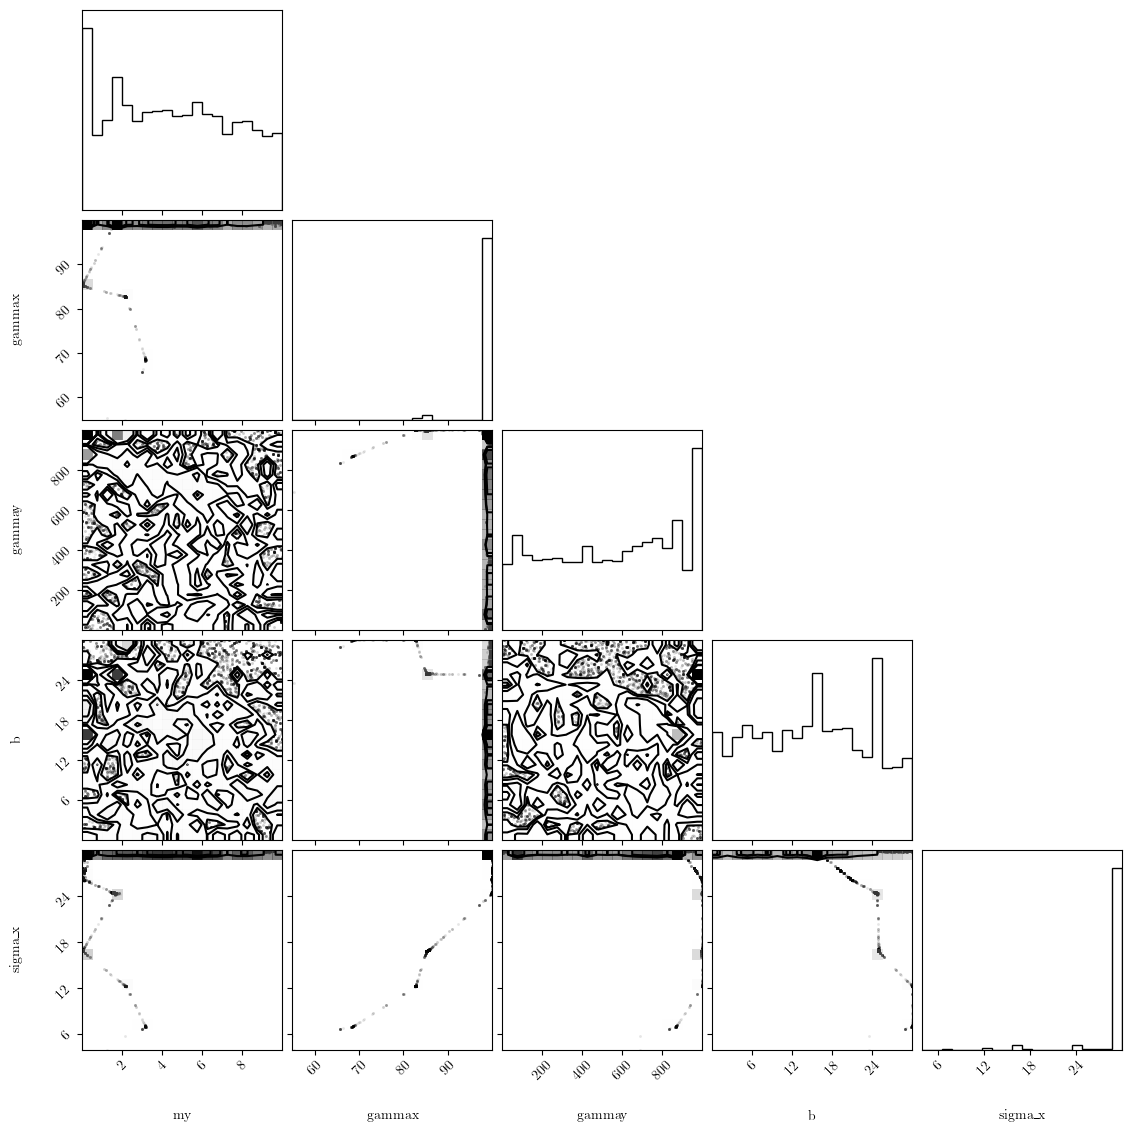

In [9]:
my_kmmh = mcmc.KMMH(ssm_cls=oscillatingKernel, prior=my_prior, data=data, niter=50000, verbose=20)
my_kmmh.run()

burnin = 0*1000
array_samples3 = np.stack([my_kmmh.chain.theta[p][burnin:] for p in prior_dict.keys()])
corner.corner(array_samples3.T, truths=None, labels=[p for p in prior_dict.keys()])
plt.savefig(f"corner_chlamydomonas_mass1_W2.png", dpi=300)